In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
from datetime import datetime, timedelta
import pandas as pd
# from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from scipy import signal as sg
from s3fs import S3FileSystem, S3Map
import scipy
from scipy import stats
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
# mle function import
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [17]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [25, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Import raw observation data and PSD processing

The raw observation data is extracted from IMOS open access ocean data at Australia NWS 400km offshore

- P1: 2012-02-02 ---- 2012-08-09
- P2: 2012-08-10 ---- 2012-12-08
- P3: 2013-01-24  ---- 2013-07-23
- P4: 2013-07-24  ---- 2014-02-01
- P5: 2014-01-31  ---- 2014-08-24

In [18]:
## Australia NWS
KIM400_temp_ncfiles_P1 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE39-59_END-20120809T114600Z_C-20171204T063704Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-299_END-20120810T042859Z_C-20171204T063629Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-392_END-20120810T004259Z_C-20171204T063608Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-49_END-20120810T034459Z_C-20171204T063707Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-69_END-20120810T031159Z_C-20171204T063701Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-89_END-20120810T015546Z_C-20171204T063655Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE39-29_END-20120809T234200Z_C-20171204T063713Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE39-79_END-20120809T042400Z_C-20171204T063658Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE56-372_END-20120810T031359Z_C-20171204T063620Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-124_END-20120810T015557Z_C-20171204T063649Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-149_END-20120810T015659Z_C-20171204T063646Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-174_END-20120810T015259Z_C-20171204T063643Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-224_END-20120810T042959Z_C-20171204T063637Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-249_END-20120810T024559Z_C-20171204T063634Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-274_END-20120810T004759Z_C-20171204T063631Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-324_END-20120810T034659Z_C-20171204T063626Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-349_END-20120810T031259Z_C-20171204T063623Z.nc',]

In [19]:
## Australia NWS
KIM400_temp_ncfiles_P2 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-298_END-20130128T012549Z_C-20171205T063330Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-323_END-20130127T085831Z_C-20171205T063326Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-348_END-20130128T015849Z_C-20171205T063323Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-123_END-20130128T020859Z_C-20171205T063353Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-148_END-20130128T020436Z_C-20171205T063350Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-173_END-20130128T013048Z_C-20171205T063346Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-223_END-20130127T094728Z_C-20171205T063339Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-248_END-20130128T015332Z_C-20171205T063336Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-273_END-20130128T011408Z_C-20171205T063333Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-48_END-20130128T014728Z_C-20171205T063413Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-68_END-20130128T004959Z_C-20171205T063406Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-78_END-20130128T011908Z_C-20171205T063403Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-88_END-20130128T003958Z_C-20171205T063400Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE39-28_END-20130128T024800Z_C-20171205T063420Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE39-58_END-20130128T031400Z_C-20171205T063410Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE56-373_END-20130127T093558Z_C-20171205T063320Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE56-391_END-20130128T013558Z_C-20171205T063306Z.nc',
]

In [20]:
KIM400_temp_ncfiles_P3 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-123_END-20130722T065101Z_C-20171205T080703Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-148_END-20130722T081549Z_C-20171205T080700Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-173_END-20130722T081409Z_C-20171205T080657Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-223_END-20130722T082639Z_C-20171205T080651Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-248_END-20130722T062909Z_C-20171205T080648Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-273_END-20130722T074139Z_C-20171205T080645Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-298_END-20130722T073049Z_C-20171205T080642Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-323_END-20130722T071409Z_C-20171205T080639Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-348_END-20130722T063959Z_C-20171205T080636Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-373_END-20130722T062229Z_C-20171205T080633Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-391_END-20130722T074049Z_C-20171205T080620Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-48_END-20130722T083909Z_C-20171205T080722Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-68_END-20130722T083639Z_C-20171205T080716Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-78_END-20130722T071319Z_C-20171205T080713Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-88_END-20130722T085049Z_C-20171205T080710Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130125T000000Z_KIM400_FV01_KIM400-1301-SBE39-58_END-20130723T064400Z_C-20171205T080719Z.nc',
]

In [21]:
KIM400_temp_ncfiles_P4 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-84_END-20140130T060948Z_C-20171205T092501Z.nc',    
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-119_END-20140130T004451Z_C-20171205T092454Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-144_END-20140129T092959Z_C-20171205T092451Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-169_END-20140130T035459Z_C-20171205T092448Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-219_END-20140130T060049Z_C-20171205T092441Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-244_END-20140130T035959Z_C-20171205T092438Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-24_END-20140130T035222Z_C-20171205T092520Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-269_END-20140130T055909Z_C-20171205T092435Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-294_END-20140130T041139Z_C-20171205T092432Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-319_END-20140130T041319Z_C-20171205T092429Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-344_END-20140130T054409Z_C-20171205T092425Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-369_END-20140129T092908Z_C-20171205T092422Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-387_END-20140130T011819Z_C-20171205T092409Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-44_END-20140130T034511Z_C-20171205T092514Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-64_END-20140129T093049Z_C-20171205T092507Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130725T000000Z_KIM400_FV01_KIM400-1307-SBE39-54_END-20140201T102800Z_C-20171205T092510Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130725T000000Z_KIM400_FV01_KIM400-1307-SBE39-74_END-20140201T115400Z_C-20171205T092504Z.nc',
]

In [22]:
KIM400_temp_ncfiles_P5 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140111T000000Z_KIM400_FV01_KIM400-1401-SBE56-391.4_END-20140824T071629Z_C-20171211T020550Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-123.4_END-20140824T080229Z_C-20171211T020635Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-148.4_END-20140824T064759Z_C-20171211T020632Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-173.4_END-20140824T084629Z_C-20171211T020629Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-223.4_END-20140824T083129Z_C-20171211T020622Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-28.4_END-20140824T074529Z_C-20171211T020702Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-48.4_END-20140824T073129Z_C-20171211T020655Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-68.4_END-20140824T093929Z_C-20171211T020648Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-88.4_END-20140824T090329Z_C-20171211T020642Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140130T000000Z_KIM400_FV01_KIM400-1401-SBE39-58.4_END-20140824T100000Z_C-20171211T020652Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140130T000000Z_KIM400_FV01_KIM400-1401-SBE39-78.4_END-20140824T090500Z_C-20171211T020645Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-248.4_END-20140824T062159Z_C-20171211T020619Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-273.4_END-20140824T092759Z_C-20171211T020616Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-298.4_END-20140824T063459Z_C-20171211T020613Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-323.4_END-20140824T100559Z_C-20171211T020609Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-348.4_END-20140824T055959Z_C-20171211T020606Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-373.4_END-20140824T091659Z_C-20171211T020603Z.nc',
]

Site & Equipment detail: https://data.aims.gov.au/moorings/IMOS-KimberleyTransect/KIM400-1202_instruments.html


In [23]:
from functions import Processing
from speccy import sick_tricks as gary

## Show an example

In [24]:
# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/DWM/')
for item in aodn:
    print(item)

imos-data/IMOS/DWM/ASFS
imos-data/IMOS/DWM/DA
imos-data/IMOS/DWM/Deployments
imos-data/IMOS/DWM/SOTS


In [25]:
sitename = 'KIM400'
# for example: choose a depth to perform analysis
example_ds = Processing.Open_file_nocache(KIM400_temp_ncfiles_P5[12], fs)
example_ds.load()
example_ds

<xarray.Dataset>
Dimensions:                (TIME: 295049)
Coordinates:
  * TIME                   (TIME) datetime64[ns] 2014-01-31T12:00:00 ... 2014...
    LATITUDE               float64 -15.22
    LONGITUDE              float64 121.1
    NOMINAL_DEPTH          float32 273.4
Data variables:
    TIMESERIES             int32 1
    TEMP                   (TIME) float32 24.49 24.69 24.84 ... 21.12 21.52
    TEMP_quality_control   (TIME) float32 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    DEPTH                  (TIME) float32 0.6492 0.6503 0.6515 ... nan nan nan
    DEPTH_quality_control  (TIME) float32 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
Attributes: (12/59)
    abstract:                         The Queensland and Northern Australia m...
    acknowledgement:                  Any users of IMOS data are required to ...
    author:                           Australian Institute of Marine Science
    author_email:                     adc@aims.gov.au
    cdm_data_type:                    Station
    citation:                         The citation in a list of references is...
    ...                               ...
    toolbox_input_file:               /export/imos/Processed/KIM/KIM400/KIM40...
    toolbox_version:                  2.5.36 - GLNXA64
    compliance_checks_passed:         cf imos:1.4
    compliance_checker_version:       2.3.1
    compliance_checker_imos_version:  1.1.3
    history:                          2017-12-11T02:07:34Z - depthPP: Depth i...

In [26]:
obs_time = example_ds.TIME.values
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 
obs_sample_interval # second

59.999996416

In [27]:
for i in KIM400_temp_ncfiles_P4:
    ds = Processing.Open_file_nocache(i, fs)
    obs_time =ds.TIME.values
    obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
    print(obs_sample_interval) # second

29.999998208
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
50.000000256
120.000002816
120.000002816


In [28]:
# Find the water depth
instrument_nominal_depth = example_ds.instrument_nominal_depth
total_depth = example_ds.site_depth_at_deployment
instrument_nominal_depth,total_depth

(273.4, 396.4)

In [29]:
# Calculate the Coriolis frequency
lat = example_ds.LATITUDE.values
lon = example_ds.LONGITUDE.values
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_coriolis_cpd = np.abs(f_coriolis*86400/(2*np.pi))
print('Coriolis frequency is',f_coriolis_cpd, 'cpd')
print(lat,lon)
#Principal lunar semidiurnal
M2_freq = 0.0805*24 #cpd
M4_freq = 2*M2_freq
#Lunar elliptic semidiurnal
N2_freq = 0.0790*24 #cpd

#Princinpal lunar diurnal
O1_freq = 0.0387*24 #cpd

#Lunisolar diurnal
K1_freq = 0.0418*24 #cpd

#Principal solar semidiurnal
S2_freq = 0.0833*24 #cpd

xcoords = [f_coriolis_cpd,O1_freq,K1_freq,M2_freq,S2_freq]
xcoords_label = ['Coriolis_freq', 'K1', 'O1','M2','S2']
xcoords_color = ['orange', 'c', 'm','r','b','g']

Coriolis frequency is 0.5250941365946958 cpd
-15.22125 121.1149666667


## Grid and Windowing the temp data 

Remove the depth average velocity (barotropic) and left "baoclinic) velocity

Remove the time average velocity and left zero mean data

Replace the bad quality data with 0

In [30]:
window_days = 80

# Period 1
Time_P1, Depths_P1, Temp_data_P1, Temp_badidx_P1 = Processing.Collect_temp(KIM400_temp_ncfiles_P1)

Window_idx_List             = Processing.Find_window_idx(Time_P1,window_days=window_days)
Time_P1_Window              = Processing.Windowing(Time_P1,Window_idx_List )
Temp_data_P1_Window_raw     = Processing.Windowing(Temp_data_P1,Window_idx_List )
Temp_badidx_P1_Window       = Processing.Windowing(Temp_badidx_P1,Window_idx_List )

In [31]:
# Period 2
Time_P2, Depths_P2, Temp_data_P2, Temp_badidx_P2 = Processing.Collect_temp(KIM400_temp_ncfiles_P2)

Window_idx_List             = Processing.Find_window_idx(Time_P2,window_days=window_days)
Time_P2_Window              = Processing.Windowing(Time_P2,Window_idx_List )
Temp_data_P2_Window_raw     = Processing.Windowing(Temp_data_P2,Window_idx_List )
Temp_badidx_P2_Window       = Processing.Windowing(Temp_badidx_P2,Window_idx_List )

In [32]:
# Period 3
Time_P3, Depths_P3, Temp_data_P3, Temp_badidx_P3 = Processing.Collect_temp(KIM400_temp_ncfiles_P3)

Window_idx_List             = Processing.Find_window_idx(Time_P3,window_days=window_days)
Time_P3_Window              = Processing.Windowing(Time_P3,Window_idx_List )
Temp_data_P3_Window_raw     = Processing.Windowing(Temp_data_P3,Window_idx_List )
Temp_badidx_P3_Window       = Processing.Windowing(Temp_badidx_P3,Window_idx_List )

In [33]:
# Period 4
Time_P4, Depths_P4, Temp_data_P4, Temp_badidx_P4 = Processing.Collect_temp(KIM400_temp_ncfiles_P4)

Window_idx_List             = Processing.Find_window_idx(Time_P4,window_days=window_days)
Time_P4_Window              = Processing.Windowing(Time_P4,Window_idx_List )
Temp_data_P4_Window_raw     = Processing.Windowing(Temp_data_P4,Window_idx_List )
Temp_badidx_P4_Window       = Processing.Windowing(Temp_badidx_P4,Window_idx_List )

In [34]:
# Period 5
Time_P5, Depths_P5, Temp_data_P5, Temp_badidx_P5 = Processing.Collect_temp(KIM400_temp_ncfiles_P5)

Window_idx_List             = Processing.Find_window_idx(Time_P5,window_days=window_days)
Time_P5_Window              = Processing.Windowing(Time_P5,Window_idx_List )
Temp_data_P5_Window_raw     = Processing.Windowing(Temp_data_P5,Window_idx_List )
Temp_badidx_P5_Window       = Processing.Windowing(Temp_badidx_P5,Window_idx_List )

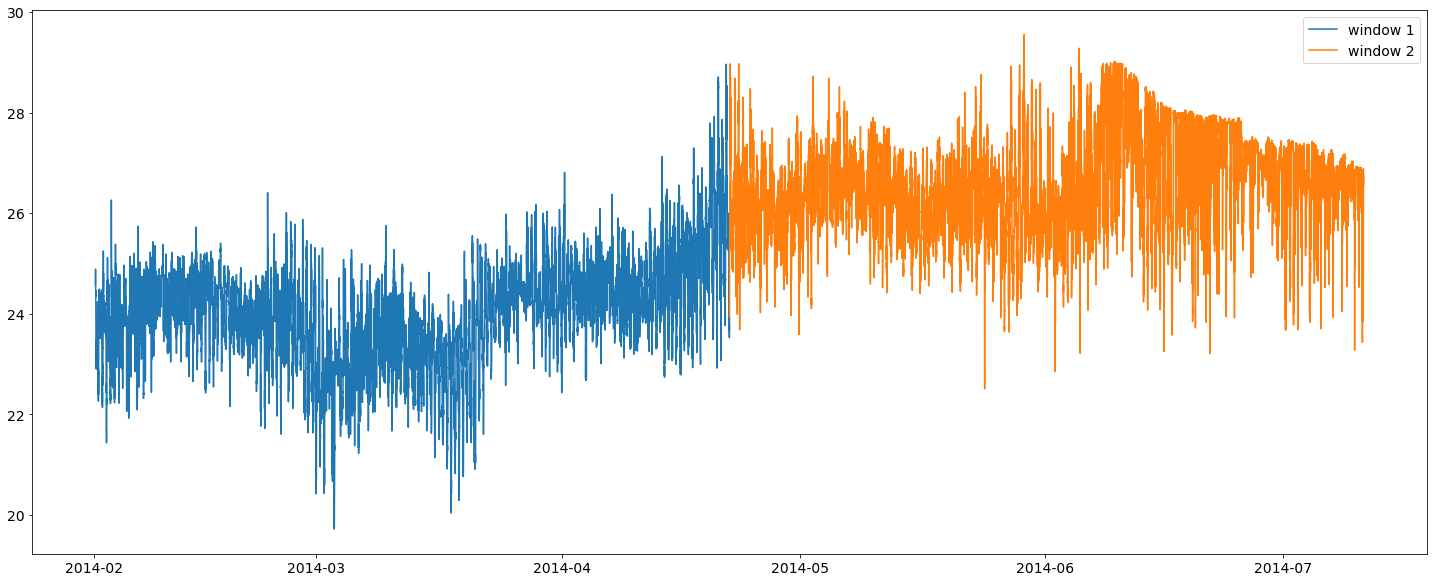

In [35]:
for i in range(len(Time_P5_Window[10])):
    plt.plot(Time_P5_Window[10][i],Temp_data_P5_Window_raw[10][i],label='window {}'.format(i+1))
plt.legend()

In [36]:
Temp_data_P1_Window,Temp_data_P1_Window_no_mean = Processing.Remove_mean(Temp_data_P1_Window_raw,Temp_badidx_P1_Window )
Temp_data_P2_Window,Temp_data_P2_Window_no_mean = Processing.Remove_mean(Temp_data_P2_Window_raw,Temp_badidx_P2_Window )
Temp_data_P3_Window,Temp_data_P3_Window_no_mean = Processing.Remove_mean(Temp_data_P3_Window_raw,Temp_badidx_P3_Window )
Temp_data_P4_Window,Temp_data_P4_Window_no_mean = Processing.Remove_mean(Temp_data_P4_Window_raw,Temp_badidx_P4_Window )
Temp_data_P5_Window,Temp_data_P5_Window_no_mean = Processing.Remove_mean(Temp_data_P5_Window_raw,Temp_badidx_P5_Window )

## Collect the obs information 

In [37]:
year_list_P1,start_date_list_P1,end_date_list_P1 = Processing.Find_window_label(Time_P1_Window)
year_list_P2,start_date_list_P2,end_date_list_P2 = Processing.Find_window_label(Time_P2_Window)
year_list_P3,start_date_list_P3,end_date_list_P3 = Processing.Find_window_label(Time_P3_Window)
year_list_P4,start_date_list_P4,end_date_list_P4 = Processing.Find_window_label(Time_P4_Window)
year_list_P5,start_date_list_P5,end_date_list_P5 = Processing.Find_window_label(Time_P5_Window)

In [38]:
#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1 = Processing.Find_mean_temp(Temp_data_P1_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P2 = Processing.Find_mean_temp(Temp_data_P2_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P3 = Processing.Find_mean_temp(Temp_data_P3_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P4 = Processing.Find_mean_temp(Temp_data_P4_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P5 = Processing.Find_mean_temp(Temp_data_P5_Window,cutoff_freq,nyquist_freq)

In [39]:
#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1_no_mean = Processing.Find_mean_temp(Temp_data_P1_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P2_no_mean = Processing.Find_mean_temp(Temp_data_P2_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P3_no_mean = Processing.Find_mean_temp(Temp_data_P3_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P4_no_mean = Processing.Find_mean_temp(Temp_data_P4_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P5_no_mean = Processing.Find_mean_temp(Temp_data_P5_Window_no_mean,cutoff_freq,nyquist_freq)

# Using harmonic analysis as the mean function

In [40]:
from functions import Harmonics

$$
\begin{bmatrix}y_1\\y_2\\y_3\\...\\y_n\end{bmatrix}=\begin{bmatrix}\cos(2\pi*p_1x_1)&\cos(2\pi*p_2x_1)&\cos(2\pi*p_3x_1)&\cos(2\pi*p_4x_1)&sin(2\pi*p_1x_1)&\sin(2\pi*p_2*x_1)&\sin(2\pi*p_3x_1)&\sin(2\pi*p_4x_1)\\\cos(2\pi*p_1x_2)&\cos(2\pi*p_2x_2)&\cos(2\pi*p_3x_2)&sin(2\pi*p_1x_2)&\sin(2\pi*p_2*x_2)&\sin(2\pi*p_3x_2)&\cos(2\pi*p_4x_2)&\sin(2\pi*p_4x_2)\\\cos(2\pi*p_1x_3)&sin(2\pi*p_1x_3)&\cos(2\pi*p_2x_3)&\sin(2\pi*p_2*x_3)&\cos(2\pi*p_3x_3)&\sin(2\pi*p_3x_3)&\cos(2\pi*p_4x_3)&\sin(2\pi*p_4x_3)\\...\\\cos(2\pi*p_1x_n)&sin(2\pi*p_1x_n)&\cos(2\pi*p_2x_n)&\sin(2\pi*p_2*x_n)&\cos(2\pi*p_3x_n)&\sin(2\pi*p_3x_n)&\cos(2\pi*p_4x_n)&\sin(2\pi*p_4x_n)\end{bmatrix}\begin{bmatrix}a_1\\a_2\\a_3\\a_4\\b_1\\b_2\\b_3\\b_4\end{bmatrix}+\epsilon
$$ 

$$
 \underline{y}=X \underline{\beta}+ \underline{\epsilon}
$$

From Gauss–Markov theorem:
$$
	\hat{\beta}=(X^TX)^{-1}X^Ty
$$

## Show an example of harmonic analysis

In [41]:
# total depth is ~400m
interest_depth = 174
idx = Depths_P1.index(interest_depth)
y = Temp_data_P1_Window_no_mean[idx][0] #remove the depth avg velocity
obs_time = Time_P1_Window[idx][0]
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 

N = len(y)
time_length = len(y)
x  = np.linspace(0,obs_sample_interval_days*N,N)#[:,None]
Xd = Harmonics.Mean_X(x)
mean_params = Harmonics.OLS(Xd,y)
yd_mean = Harmonics.Prior_mean_function(x,mean_params)
ϵ =  y - yd_mean #residual

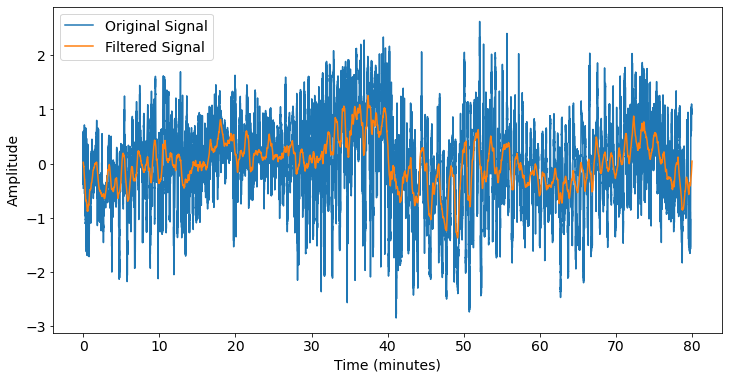

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Function to apply a moving average filter to a signal
def moving_average_filter(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

# Generate example data (replace this with your actual data)
fs = obs_sample_interval_days  # Sample rate in Hz (1 sample per minute)

signal = y

# Define the lowpass filter parameter
cutoff_cycles_per_day = f_coriolis_cpd

# Convert cutoff frequency to the corresponding index
cutoff_index = int(f_coriolis_cpd/obs_sample_interval_days )  # Convert cycles per day to samples per minute

# Apply the lowpass filter to the signal using a moving average filter
filtered_signal = moving_average_filter(signal, cutoff_index)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(x, signal, label='Original Signal')
plt.plot(x, filtered_signal, label='Filtered Signal')
plt.xlabel('Time (minutes)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

(1e-05, 1.0)

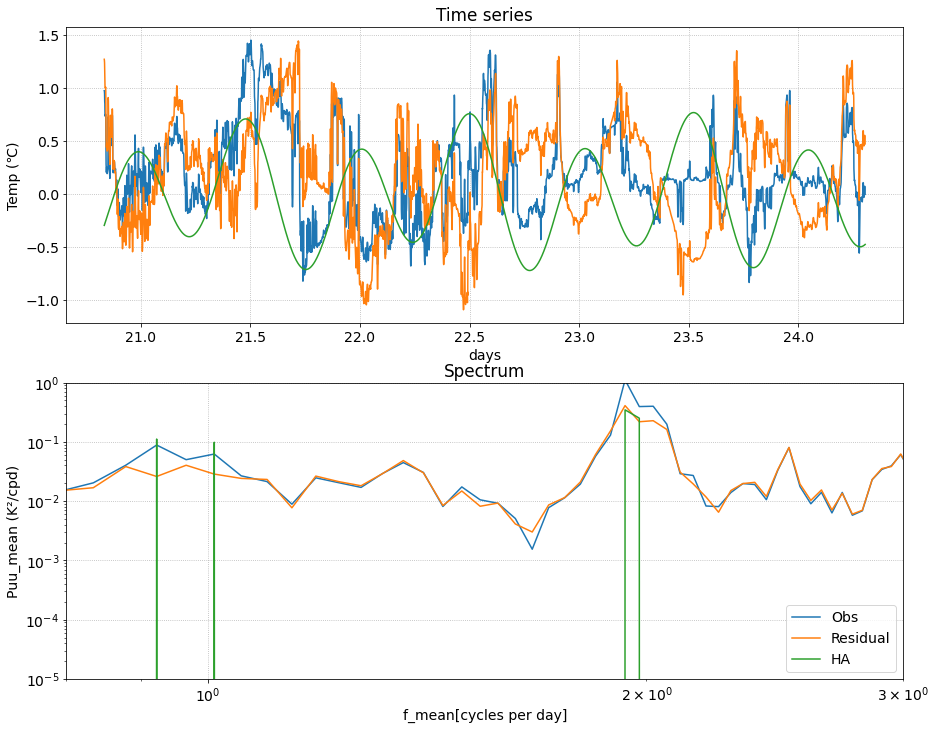

In [43]:
f_mean, Puu_mean  = Processing.Welch(yd_mean,obs_sample_interval_days)
f_ϵ,Puu_ϵ         = Processing.Welch(ϵ,obs_sample_interval_days)
f_obs_w,pvv_obs_w = Processing.Welch(y,obs_sample_interval_days)

peaks = Processing.Coherent_peaks(xcoords[1:],mean_params,f_mean)

plt.figure(figsize=(15,12))
plt.subplot(2, 1, 1)
idx = 35000
plt.plot(x[30000:idx],y[30000:idx],label='Obs')
plt.plot(x[30000:idx],ϵ[30000:idx],label = 'Residual')
plt.plot(x[30000:idx],yd_mean[30000:idx],label='HA')
plt.xlabel('days')
plt.ylabel('Temp (℃)')
plt.grid(b=True,ls=':')
plt.title('Time series')

plt.subplot(2, 1, 2)
plt.plot(f_obs_w,pvv_obs_w,label='Obs')
plt.plot(f_ϵ,Puu_ϵ,label='Residual')
plt.plot(f_obs_w,peaks,label='HA')
plt.xscale("log")
plt.yscale("log")

plt.xlabel('f_mean[cycles per day]')
plt.ylabel('Puu_mean (K²/cpd)')
plt.grid(b=True,ls=':')
plt.legend(loc="lower right")
plt.title('Spectrum'.format(interest_depth))
plt.xlim(0.8,3)
plt.ylim(1e-5, 1e0)

## Perform the HA

In [44]:
# remove mean is added into the cal_harmonics_spectrum_depth_profile function
Mean_params_P1, Mean_funcs_P1, F_p_P1, P_p_P1_raw, F_w_P1,P_w_P1_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P1_Window,Depths_P1,Temp_data_P1_Window_no_mean )
Mean_params_P2, Mean_funcs_P2, F_p_P2, P_p_P2_raw, F_w_P2,P_w_P2_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P2_Window,Depths_P2,Temp_data_P2_Window_no_mean )
Mean_params_P3, Mean_funcs_P3, F_p_P3, P_p_P3_raw, F_w_P3,P_w_P3_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P3_Window,Depths_P3,Temp_data_P3_Window_no_mean )
Mean_params_P4, Mean_funcs_P4, F_p_P4, P_p_P4_raw, F_w_P4,P_w_P4_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P4_Window,Depths_P4,Temp_data_P4_Window_no_mean )
Mean_params_P5, Mean_funcs_P5, F_p_P5, P_p_P5_raw, F_w_P5,P_w_P5_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P5_Window,Depths_P5,Temp_data_P5_Window_no_mean )

HA_var_P1 = Harmonics.Cal_var_from_mean_funcs(Mean_funcs_P1)
HA_var_P2 = Harmonics.Cal_var_from_mean_funcs(Mean_funcs_P2)
HA_var_P3 = Harmonics.Cal_var_from_mean_funcs(Mean_funcs_P3)
HA_var_P4 = Harmonics.Cal_var_from_mean_funcs(Mean_funcs_P4)
HA_var_P5 = Harmonics.Cal_var_from_mean_funcs(Mean_funcs_P5)

C:\Users\21924032\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 32768 is greater than input length  = 23041, using nperseg = 23041
  warnings.warn('nperseg = {0:d} is greater than input length '


(1e-07, 10)

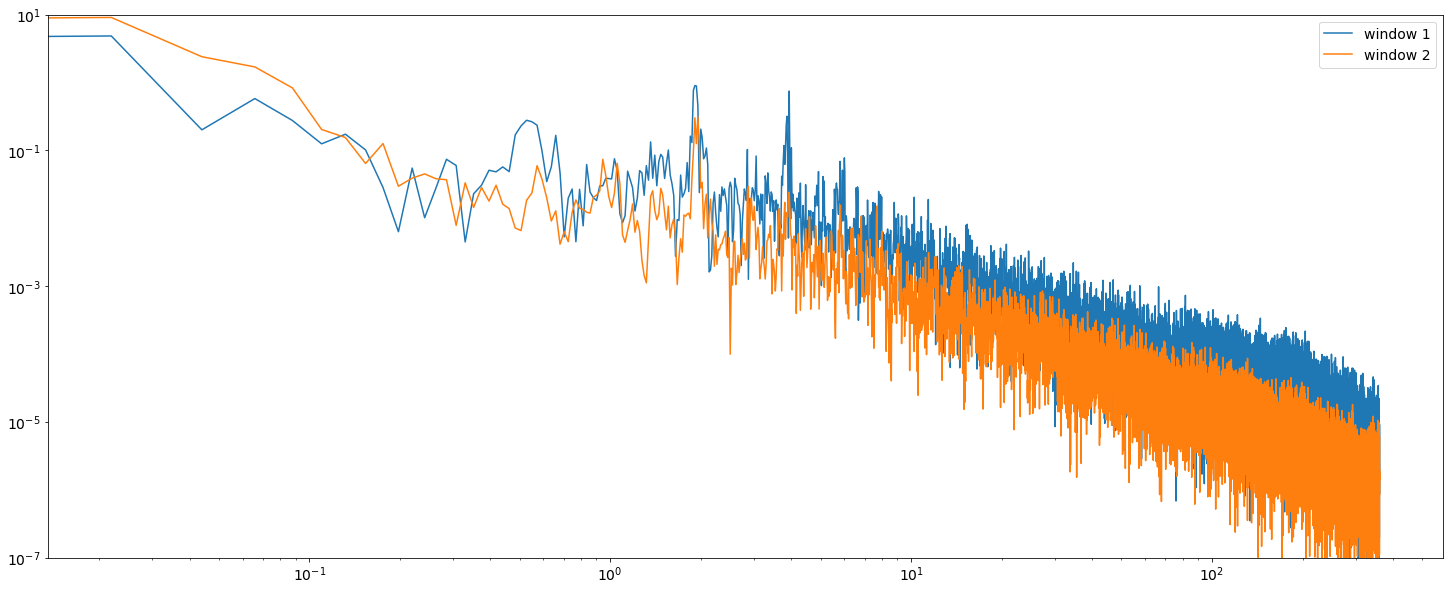

In [45]:
for i in range(len(F_w_P1[0])):
    plt.loglog(F_w_P1[0][i],P_w_P1_raw[0][i],label='window {}'.format(i+1))
plt.legend()
plt.ylim(1e-7,10)

## Scaling the periodogram similar to Parzen1996

In [46]:
P_p_P1 = Processing.Scale_periodogram(P_p_P1_raw,Temp_badidx_P1_Window)
P_p_P2 = Processing.Scale_periodogram(P_p_P2_raw,Temp_badidx_P2_Window)
P_p_P3 = Processing.Scale_periodogram(P_p_P3_raw,Temp_badidx_P3_Window)
P_p_P4 = Processing.Scale_periodogram(P_p_P4_raw,Temp_badidx_P4_Window)
P_p_P5 = Processing.Scale_periodogram(P_p_P5_raw,Temp_badidx_P5_Window)

P_w_P1 = Processing.Scale_periodogram(P_w_P1_raw,Temp_badidx_P1_Window)
P_w_P2 = Processing.Scale_periodogram(P_w_P2_raw,Temp_badidx_P2_Window)
P_w_P3 = Processing.Scale_periodogram(P_w_P3_raw,Temp_badidx_P3_Window)
P_w_P4 = Processing.Scale_periodogram(P_w_P4_raw,Temp_badidx_P4_Window)
P_w_P5 = Processing.Scale_periodogram(P_w_P5_raw,Temp_badidx_P5_Window)

Text(0.5, 1.0, 'Comparisoon of Raw and Scalled periodogram at 89m')

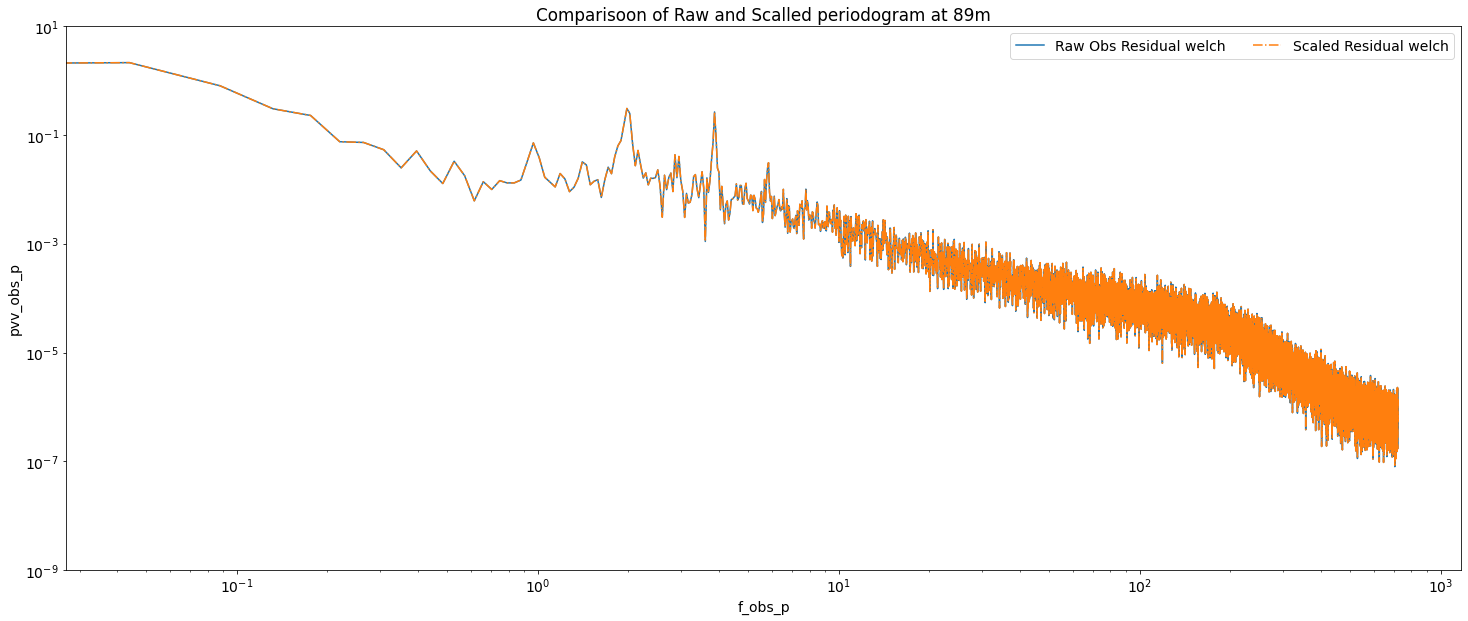

In [47]:
interest_depth = 89
idx = Depths_P1.index(interest_depth)
# plt.plot(F_residual_p[idx],P_residual_p_raw[idx],'-',label='Raw Obs Residual')
# plt.plot(F_residual_p[idx],P_residual_p[idx],'-.',label='Scaled Residual Periodogram')

plt.plot(F_w_P1[idx][1],P_w_P1_raw[idx][1],'-',label='Raw Obs Residual welch')
plt.plot(F_w_P1[idx][1],P_w_P1[idx][1],'-.',label='Scaled Residual welch')

# for j in range(len(xcoords)):
#     plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j])
plt.ylim(1e-9, 1e1)
plt.legend(ncol=3)
#     plt.xlim(0.1, 10)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparisoon of Raw and Scalled periodogram at {}m'.format(interest_depth))

# Specify the horizontal domain, bathymetry section and vertical density profile

In [48]:
from functions import Bathmetry

In [49]:
#bathy_params = [H, h0, x0, lt]  # See the depth_tanh function for the mean

# bathy_params = [600, 450, 75e3, 70e3]  #set 1
#bathy_params = [300, 200,75e3,70e3] #set 2
bathy_params = [400,200,75e3, 70e3] #set 3

N = 16000  # Number of grid points
dx = 25.  # horizontal grid spacing

# The horizontal domain
x = np.arange(0, N * dx, dx)

# The depth
h = Bathmetry.Depth_tanh(bathy_params, x)

In [50]:
# See the references above for the mean of the,
#set 1
rho_params =[1025.66780468, # Mean density,             beta0
     1.5, # Density jump,                        beta1
     150,# Depth of the second pycnocline      beta4
     50, # Width of the second pycnocline     beta5
        ]
# Number of vertical levels
Nz = 40
#z = np.linspace(-H,0,Nz)
# z = np.linspace(-bathy_params[0],0,Nz) #bathy_params[0]=H
z = np.arange(-400,1,10)
# rhoz = rho_double_tanh(rho_params,z)
rhoz = Bathmetry.Single_tanh(z,rho_params)
# rhoz = constant_N(rho_params,z)

Text(0.5, 1.0, 'Stratification')

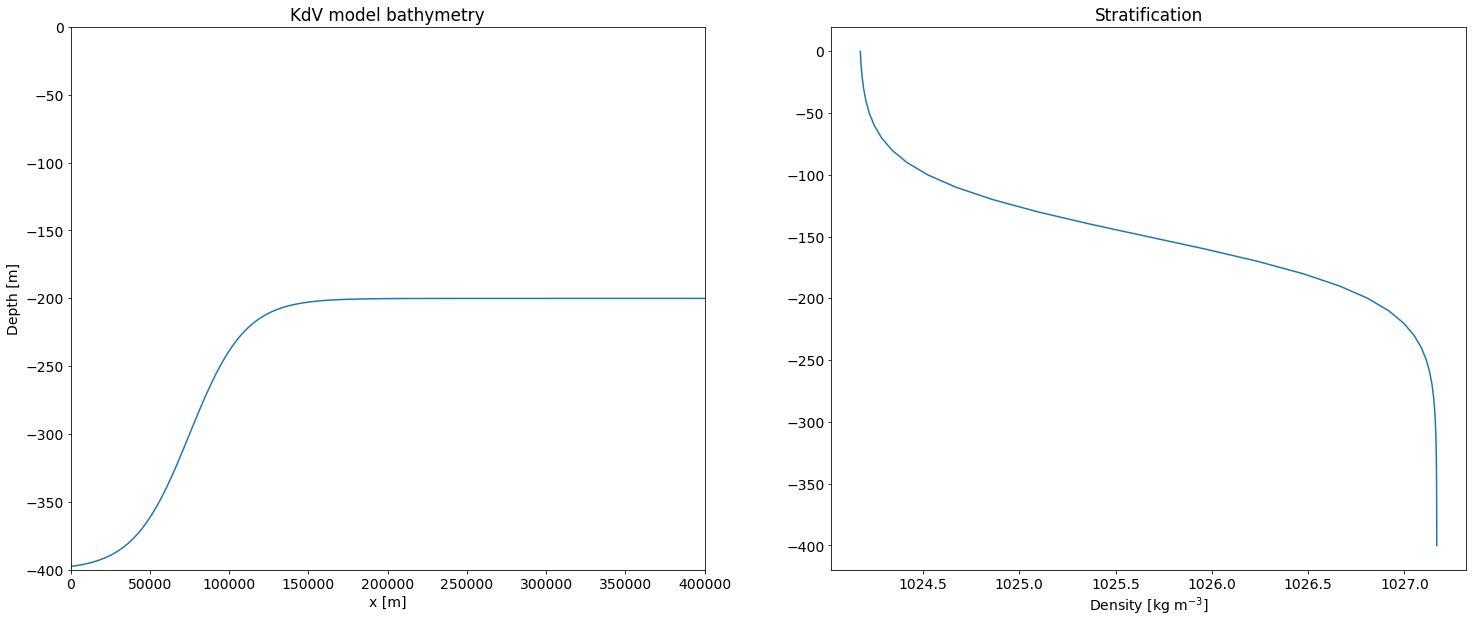

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -h)  #negative bc depth
ax1.set_title('KdV model bathymetry')
ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('x [m]')
#plt.ylim(-H, 0)
ax1.set_ylim(-bathy_params[0], 0)
ax1.set_xlim(0, dx * N)

ax2.plot(rhoz, z)
# plt.xticks(np.arange(min(rhoz), max(rhoz), 0.5))
# ax2.set_ylabel('Depth [m]')
ax2.set_xlabel('Density [kg m$^{-3}$]')
ax2.set_title('Stratification')
# ax2.xaxis.tick_top()

## From the vertical density profile to find the vertical structure

(array([0.        , 0.07687536, 0.15373435, 0.23054468, 0.30724678,
        0.38373557, 0.45983197, 0.53524007, 0.60948584, 0.681836  ,
        0.75120433, 0.81607009, 0.87446053, 0.92407239, 0.9625925 ,
        0.98818855, 1.        , 0.99838514, 0.98478656, 0.96130184,
        0.93018943, 0.89350164, 0.85290635, 0.80965839, 0.76465216,
        0.71850136, 0.67161585, 0.62426405, 0.57661921, 0.52879187,
        0.4808519 , 0.43284309, 0.38479268, 0.33671745, 0.28862765,
        0.24052946, 0.1924266 , 0.14432123, 0.09621459, 0.04810739,
        0.        ]),
 1.4287273869388653,
 210.49639758034343,
 array([   0.,  -10.,  -20.,  -30.,  -40.,  -50.,  -60.,  -70.,  -80.,
         -90., -100., -110., -120., -130., -140., -150., -160., -170.,
        -180., -190., -200., -210., -220., -230., -240., -250., -260.,
        -270., -280., -290., -300., -310., -320., -330., -340., -350.,
        -360., -370., -380., -390., -400.]))

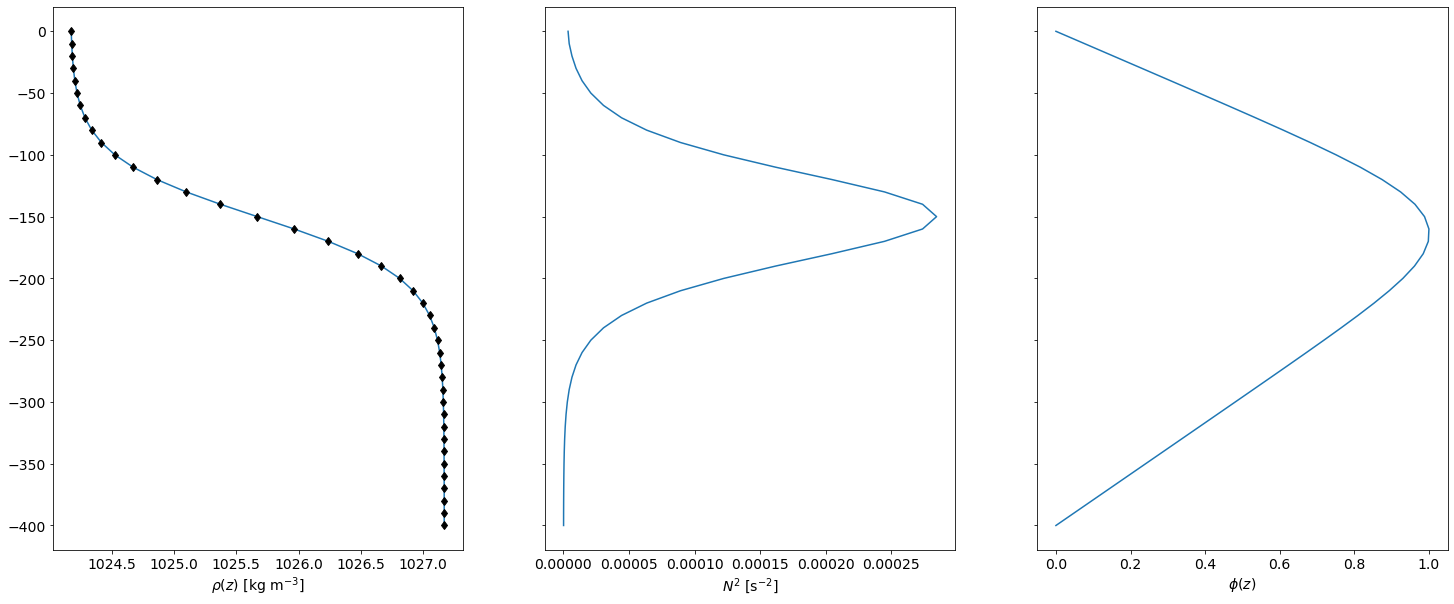

In [52]:
import iwaves
WaveModes = iwaves.IWaveModes(rhoz,z,density_func='single_tanh_rho')
zmax = -np.max(np.abs(z))
dz = z[1]-z[0]
phi_1, c1, h_e, Z = WaveModes(zmax,dz,mode=0)  # mode 1
iwaves.IWaveModes.plot_modes(WaveModes)
phi_1, c1, h_e,Z

In [53]:
phi_depth_profile = xr.DataArray(phi_1, coords={'depth': Z}, dims=['depth'])

## Garret-Munk Spectral Model

In [114]:
# Garret-Munk 
from functions import GM81 as gm
# Coriolis frequency
f = f_coriolis_cpd/86400 #hz
# buoyancy frequency (corresponding to 1000 m depth)
buoyancy_freq = 200
N = buoyancy_freq/86400  #hz
# surface-extrapolated buoyancy frequency
N0 = np.sqrt(WaveModes.N2)[0] #hz
# e-folding scale of N(z) # how long N(z) take to increase by e
b =1300#m
# frequency
omg = np.linspace(1.01*f, N, len(F_p_P1[0][0]))
# mode number
j = np.arange(1, 100)
# reshape to allow multiplication into 2D array
Omg = np.reshape(omg, (omg.size,1))
J = np.reshape(j, (1,j.size))
# frequency spectra (KE and PE)
K_omg_j = gm.K_omg_j(Omg, J, f, N, N0, b)
P_omg_j = gm.P_omg_j(Omg, J, f, N, N0, b)
# sum over modes
K_omg = np.sum(K_omg_j, axis=1)
P_omg = np.sum(P_omg_j, axis=1)
GM_spectrum = P_omg  #(m^2/s^2/cps)
P_omg

array([3.09505459e+03, 4.54815072e+03, 5.49969737e+03, ...,
       1.55062727e-01, 1.55051987e-01, 1.55041248e-01])

# Optimizing params for the residual function -- Whittle likelihood

Fitting in frequency domain using Whittle likelihood

$$
ℓ_W(\theta) = -\sum\limits _{\omega\in\Omega}\begin{Bmatrix}\log\hat{f}(\omega;\theta)+\frac{I(\omega)}{\hat{f}(\omega;\theta)}\end{Bmatrix}  
$$

where $\hat{f}(\omega;\theta)$ is the continuous-time process spectral density (what we expected)  and $I(\omega)$ is the periodogram (what we observed)

In [56]:
f_coriolis_cpd

0.5250941365946958

# Workflow on the Residual

Parametric 

In [57]:
from functions import Cov
from functions import Optimisation

## Define the boundary and initial guess

In [58]:
#Initia guess
IG_noise = 1.5e-5

IG_η_matern = 0.5
IG_α_matern = 1 #impact the slope

IG_eta = 0.4
IG_ℓ_exp = 3 #impact how wide the brodening of peak 1 is (proportional)  

In [59]:
##bounds
bound_noise = [0,1]
bound_η_matern = [0.01,2]
bound_α_matern = [0.5,3.5] #impact the slope                  # from matern 7/2 to matern 1/2 to matern 0
# K1_freq,O1_freq,M2_freq,S2_freq
bound_eta = [0.01,1]     # K1 peak
bound_ℓ_exp = [0.01,40]  #impact how wide the brodening of peak 1 is (reverse proportional)  peak 1 is designed to be broader than peak 2

## Select Frequency range to omit the influence of inertial and M4 peak 

Generally, the Whittle likelihood is applied to optimize the parameters for the whole frequency band of the observed periodogram (an estimation of the true spectrum). However, in our case, we selected a range of frequencies (from coriolis frequency to buoyancy frequency) to perform the optimization because the internal tide behaviors appear in this bandwidth. In addition, since the inertial and M4 peak are not the characteristics of the internal tides, they are omitted in our optimization using Whittle likelihood.

In [60]:
#subset for modelling
subset_end_freq = 35 #cpd
subset_bandwidth = 0.1#cpd
M4_freq = 2*0.0805*24 #cpd

subset_p_P1 = Processing.Subset_freq(F_p_P1,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)
subset_w_P1 = Processing.Subset_freq(F_w_P1,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)

subset_p_P2 = Processing.Subset_freq(F_p_P2,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)
subset_w_P2 = Processing.Subset_freq(F_w_P2,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)

subset_p_P3 = Processing.Subset_freq(F_p_P3,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)
subset_w_P3 = Processing.Subset_freq(F_w_P3,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)

subset_p_P4 = Processing.Subset_freq(F_p_P4,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)
subset_w_P4 = Processing.Subset_freq(F_w_P4,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)

subset_p_P5 = Processing.Subset_freq(F_p_P5,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)
subset_w_P5 = Processing.Subset_freq(F_w_P5,f_coriolis_cpd,subset_end_freq,subset_bandwidth,Omit=True,omit_freq=M4_freq)

In [61]:
F_p_P1_modulated = Processing.Select_frequency(F_p_P1,subset_p_P1)
P_p_P1_modulated = Processing.Select_frequency(P_p_P1,subset_p_P1)

F_p_P2_modulated = Processing.Select_frequency(F_p_P2,subset_p_P2)
P_p_P2_modulated = Processing.Select_frequency(P_p_P2,subset_p_P2) 

F_p_P3_modulated = Processing.Select_frequency(F_p_P3,subset_p_P3)
P_p_P3_modulated = Processing.Select_frequency(P_p_P3,subset_p_P3) 

F_p_P4_modulated = Processing.Select_frequency(F_p_P4,subset_p_P4) 
P_p_P4_modulated = Processing.Select_frequency(P_p_P4,subset_p_P4)

F_p_P5_modulated = Processing.Select_frequency(F_p_P5,subset_p_P5) 
P_p_P5_modulated = Processing.Select_frequency(P_p_P5,subset_p_P5) 

In [62]:
#subset for subtidal
#from 0 to coriolis_freq
subset_p_P1_subtidal = Processing.Subset_freq(F_p_P1,-1,f_coriolis_cpd,0,Omit=False)
subset_p_P2_subtidal = Processing.Subset_freq(F_p_P2,-1,f_coriolis_cpd,0,Omit=False)
subset_p_P3_subtidal = Processing.Subset_freq(F_p_P3,-1,f_coriolis_cpd,0,Omit=False)
subset_p_P4_subtidal = Processing.Subset_freq(F_p_P4,-1,f_coriolis_cpd,0,Omit=False)
subset_p_P5_subtidal = Processing.Subset_freq(F_p_P5,-1,f_coriolis_cpd,0,Omit=False)


In [63]:
F_p_P1_subtidal = Processing.Select_frequency(F_p_P1,subset_p_P1_subtidal)
P_p_P1_subtidal = Processing.Select_frequency(P_p_P1,subset_p_P1_subtidal)

F_p_P2_subtidal = Processing.Select_frequency(F_p_P2,subset_p_P2_subtidal)
P_p_P2_subtidal = Processing.Select_frequency(P_p_P2,subset_p_P2_subtidal)

F_p_P3_subtidal = Processing.Select_frequency(F_p_P3,subset_p_P3_subtidal)
P_p_P3_subtidal = Processing.Select_frequency(P_p_P3,subset_p_P3_subtidal)

F_p_P4_subtidal = Processing.Select_frequency(F_p_P4,subset_p_P4_subtidal)
P_p_P4_subtidal = Processing.Select_frequency(P_p_P4,subset_p_P4_subtidal)

F_p_P5_subtidal = Processing.Select_frequency(F_p_P5,subset_p_P5_subtidal)
P_p_P5_subtidal = Processing.Select_frequency(P_p_P5,subset_p_P5_subtidal)

Text(0.5, 1.0, 'Comparison of temp residual spectrum at 89m')

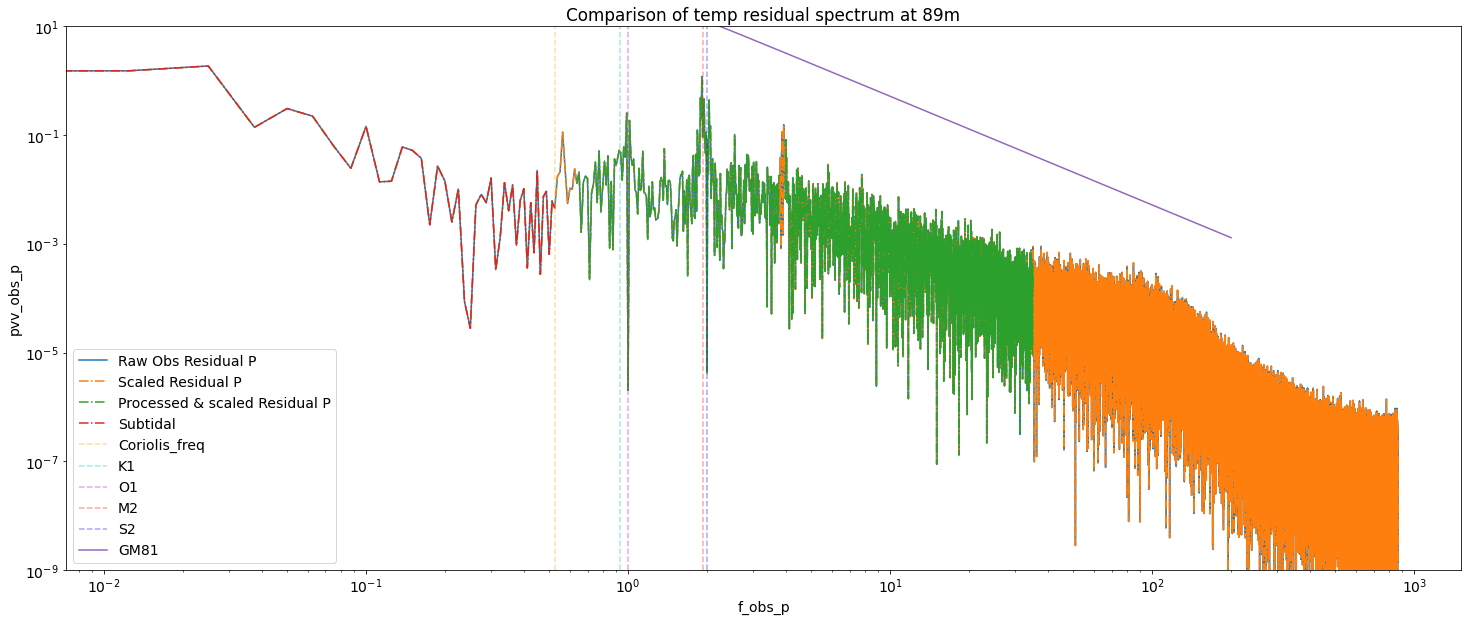

In [64]:
# show an example
# total depth is ~400m
interest_depth = 89
idx = Depths_P1.index(interest_depth)
# y = Temp_profile.temperature.sel(depth=depth_below_surface[idx]) #remove the depth avg velocity

plt.plot(F_p_P3[idx][0],P_p_P3_raw[idx][0],label='Raw Obs Residual P')
plt.plot(F_p_P3[idx][0],P_p_P3[idx][0],'-.',label='Scaled Residual P')
plt.plot(F_p_P3_modulated[idx][0],P_p_P3_modulated[idx][0],'-.',label='Processed & scaled Residual P')
plt.plot(F_p_P3_subtidal[idx][0],P_p_P3_subtidal[idx][0],'-.',label='Subtidal')
for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.35)

plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparison of temp residual spectrum at {}m'.format(interest_depth))

## Compute the signal variance

In [65]:
Var_total_P1 = Processing.Cal_var(Temp_data_P1_Window_no_mean)
Var_total_P2 = Processing.Cal_var(Temp_data_P2_Window_no_mean)
Var_total_P3 = Processing.Cal_var(Temp_data_P3_Window_no_mean)
Var_total_P4 = Processing.Cal_var(Temp_data_P4_Window_no_mean)
Var_total_P5 = Processing.Cal_var(Temp_data_P5_Window_no_mean)

In [66]:
Var_modulated_P1 = Processing.Cal_var_from_Periodogram(F_p_P1_modulated,P_p_P1_modulated)
Var_modulated_P2 = Processing.Cal_var_from_Periodogram(F_p_P2_modulated,P_p_P2_modulated)
Var_modulated_P3 = Processing.Cal_var_from_Periodogram(F_p_P3_modulated,P_p_P3_modulated)
Var_modulated_P4 = Processing.Cal_var_from_Periodogram(F_p_P4_modulated,P_p_P4_modulated)
Var_modulated_P5 = Processing.Cal_var_from_Periodogram(F_p_P5_modulated,P_p_P5_modulated)

In [67]:
Var_subtidal_P1 = Processing.Cal_var_from_Periodogram(F_p_P1_subtidal,P_p_P1_subtidal)
Var_subtidal_P2 = Processing.Cal_var_from_Periodogram(F_p_P2_subtidal,P_p_P2_subtidal)
Var_subtidal_P3 = Processing.Cal_var_from_Periodogram(F_p_P3_subtidal,P_p_P3_subtidal)
Var_subtidal_P4 = Processing.Cal_var_from_Periodogram(F_p_P4_subtidal,P_p_P4_subtidal)
Var_subtidal_P5 = Processing.Cal_var_from_Periodogram(F_p_P5_subtidal,P_p_P5_subtidal)

In [68]:
def Cal_var_from_PSD1(f,p):  
    freq_bin = f[1]-f[0]
    var = freq_bin*np.sum(p)*2
    return var

In [69]:
from speccy import sick_tricks as gary
#show an example
Δ = (Time_P4_Window[8][0][1]-Time_P4_Window[8][0][0]).astype('float')/1e9/86400
f_P4,p_P4 = gary.periodogram(Temp_data_P4_Window_no_mean[8][0],Δ)
subset_index_P4 = np.logical_and(f_coriolis_cpd+0.1 < f_P4, f_P4 < 35) & ~np.logical_and(M4_freq -0.1 < f_P4, f_P4 < M4_freq +0.1) 
print('total var is',Var_total_P4[8][0])
print('subset var is',Cal_var_from_PSD1(f_P4[subset_index_P4],p_P4[subset_index_P4]))
print('modulated*2+HA:',Var_modulated_P4[8][0]+HA_var_P4[8][0])
print('subtidal*2:',Var_subtidal_P4[8][0])
print('modulated*2+HA+subtidal*2:',Var_modulated_P4[8][0]+HA_var_P4[8][0]+Var_subtidal_P4[8][0])

total var is 0.31895742
subset var is 0.21095630342982533
modulated*2+HA: 0.21097652539290115
subtidal*2: 0.08693752343642752
modulated*2+HA+subtidal*2: 0.2979140488293287


## M1L2 Kernal

In [70]:
def M1L2(dx,params):
    
    noise_var = params[0]
    η_matern1 = params[1]
    α_matern1 = params[2]
    eta1      = params[3]
    ℓ_exp1    = params[4]
    eta2      = params[5]
    ℓ_exp2    = params[6]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)         #background energy continuum  break at 3 cpd
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=1)              #l_cos = 1 in cpd
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=2)              #l_cos = 2 in cpd
    noise = Cov.white_noise(dx,noise_var)
    COV = matern1 + peak1 + peak2 + noise
    return COV

In [71]:
def M1L2_no_noise(dx,params):
    
    O1_freq = 0.93 #cpd
    K1_freq = 1 #cpd
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
    
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=3,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=(O1_freq+K1_freq)/2)
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=(S2_freq+M2_freq)/2)
    COV = matern1 + peak1 + peak2 #+ noise
    return COV

In [72]:
#Initia guess
M1L2_covparams_ic = [ 
#                     IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,         
                    IG_eta,
                    IG_ℓ_exp,
                     ]#Semi-Diurnal frequency
#Boundary
M1L2_bounds_parameter = [
#     bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,
                    bound_eta,
                    bound_ℓ_exp,                     
]#Semi-Diurnal frequency

M1L2_parameter_name = [
#     'noise',
                    'η_matern1',
                    'ν_matern1',
                    'η_peak1',
                    'ℓ_peak1',
                    'η_peak2',
                    'ℓ_peak2', ]

In [73]:
M1L2_covparams_ic

[0.5, 1, 0.4, 3, 0.4, 3]

In [74]:
M1L2_bounds_parameter

[[0.01, 2], [0.5, 3.5], [0.01, 1], [0.01, 40], [0.01, 1], [0.01, 40]]

Run Model/

In [75]:
F_model_fit_list_P1_M1L2, P_model_fit_list_P1_M1L2, Soln_model_fit_list_P1_M1L2, Whittle_list_P1_M1L2 = Optimisation.Model_fit(P_p_P1, Time_P1_Window, subset_p_P1,
                                                                                                           M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                                                           M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.5\functions\Cov.py:121: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


not converging at depth idx of 5 and window 0


In [76]:
F_model_fit_list_P2_M1L2, P_model_fit_list_P2_M1L2, Soln_model_fit_list_P2_M1L2, Whittle_list_P2_M1L2 = Optimisation.Model_fit(P_p_P2, Time_P2_Window, subset_p_P2,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [77]:
F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, Soln_model_fit_list_P3_M1L2, Whittle_list_P3_M1L2 = Optimisation.Model_fit(P_p_P3, Time_P3_Window, subset_p_P3,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [78]:
F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, Soln_model_fit_list_P4_M1L2, Whittle_list_P4_M1L2 = Optimisation.Model_fit(P_p_P4, Time_P4_Window, subset_p_P4,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [79]:
F_model_fit_list_P5_M1L2, P_model_fit_list_P5_M1L2, Soln_model_fit_list_P5_M1L2, Whittle_list_P5_M1L2 = Optimisation.Model_fit(P_p_P5, Time_P5_Window, subset_p_P5,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

not converging at depth idx of 15 and window 1


In [80]:
time_length = len(Time_P3_Window[8][0])
obs_sample_interval_days = (Time_P3_Window[8][0][1]-Time_P3_Window[8][0][0]).astype('float')/1e9/86400

f_model_fit_P3_1, p_model_fit_P3_1, soln_model_fit_P3_1 = Optimisation.whittle_fitting(M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                          time_length,obs_sample_interval_days,
                                                                          subset_p_P3[8][0],P_p_P3[8][0],
                                                                          M1L2_no_noise)

(0.5, 220)

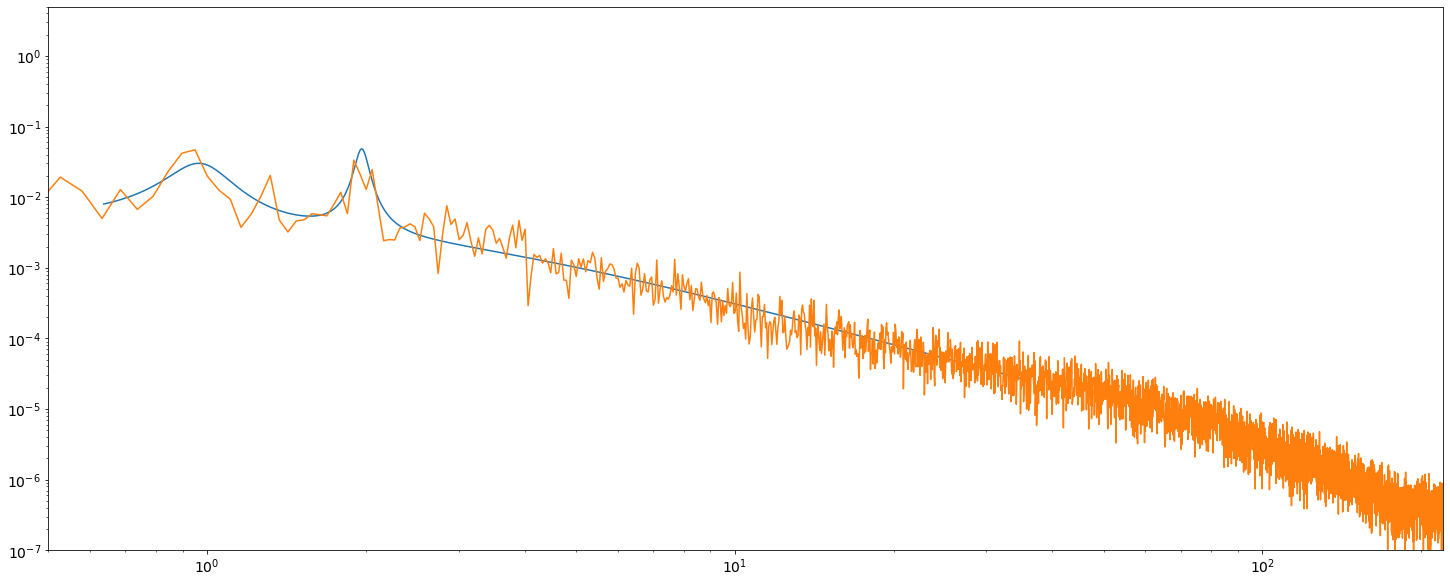

In [81]:
plt.plot(f_model_fit_P3_1,p_model_fit_P3_1)
plt.plot(F_w_P3[8][0],P_w_P3[8][0])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7, 5)
plt.xlim(0.5,220)

## Model fit results 

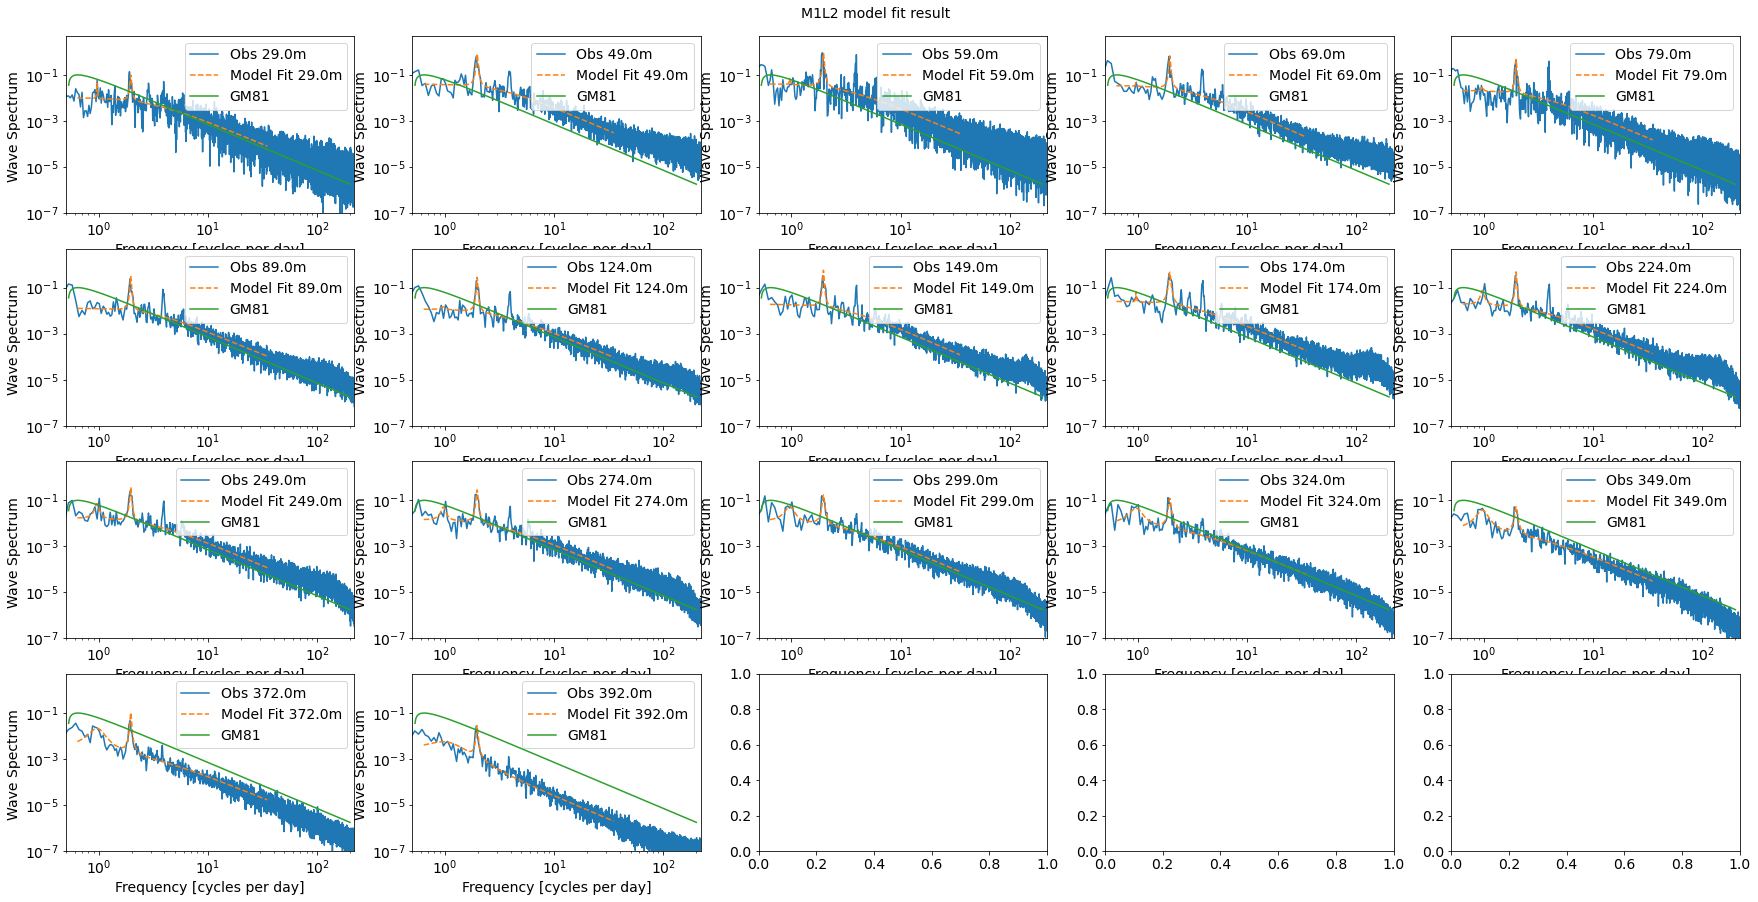

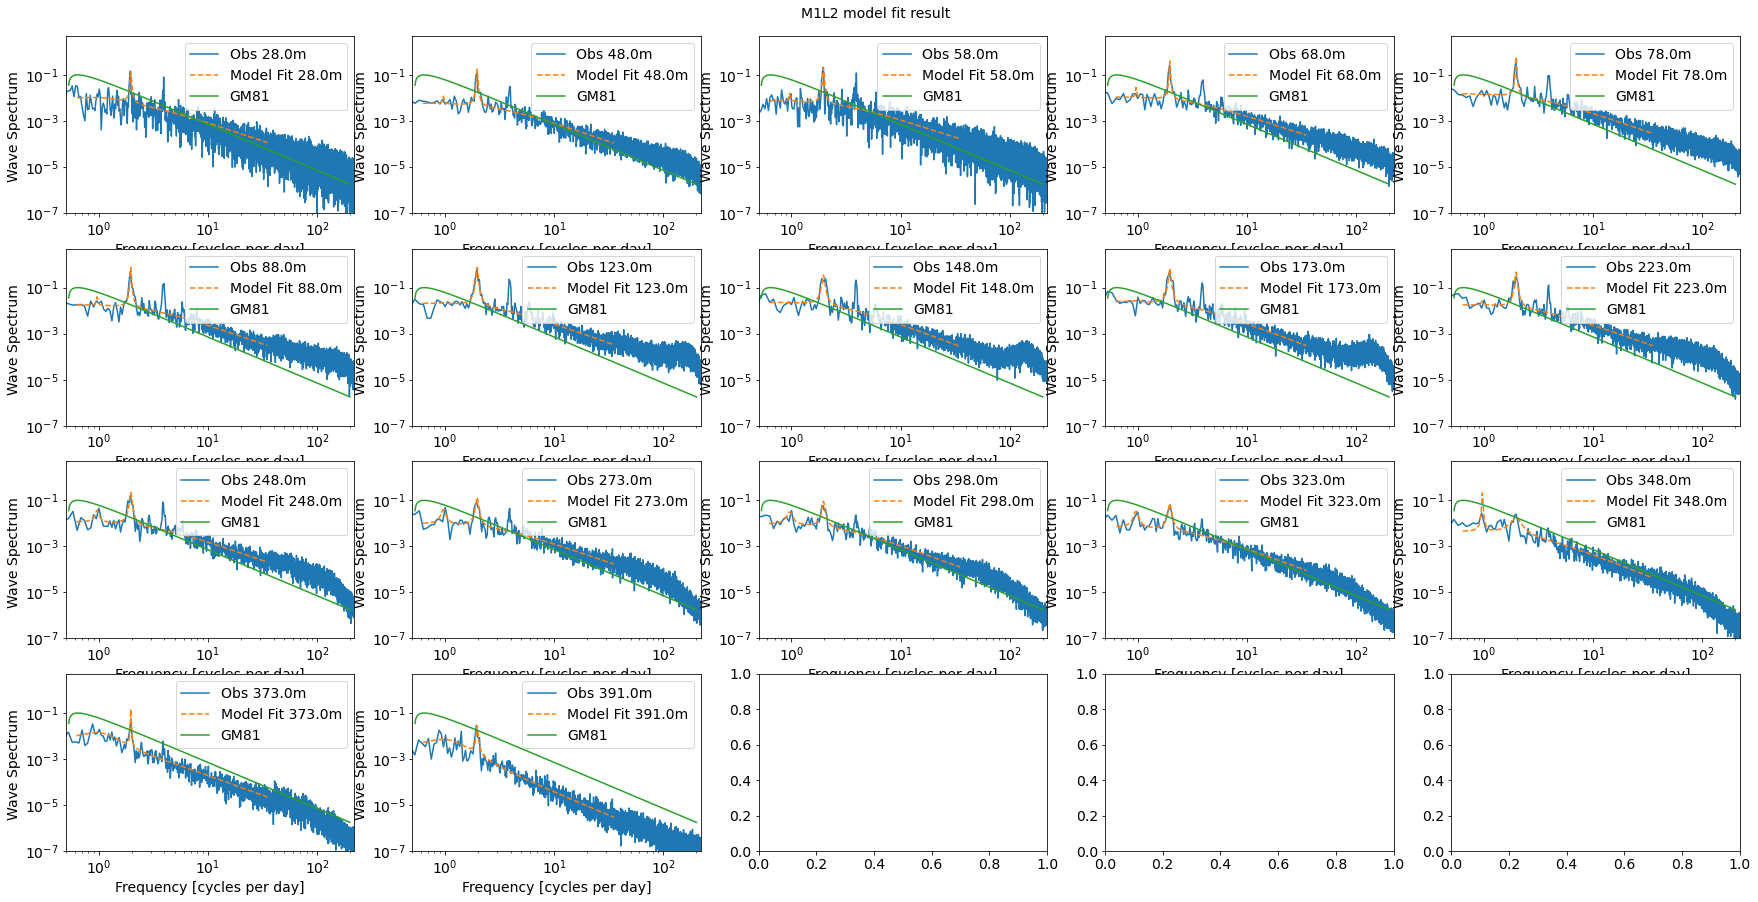

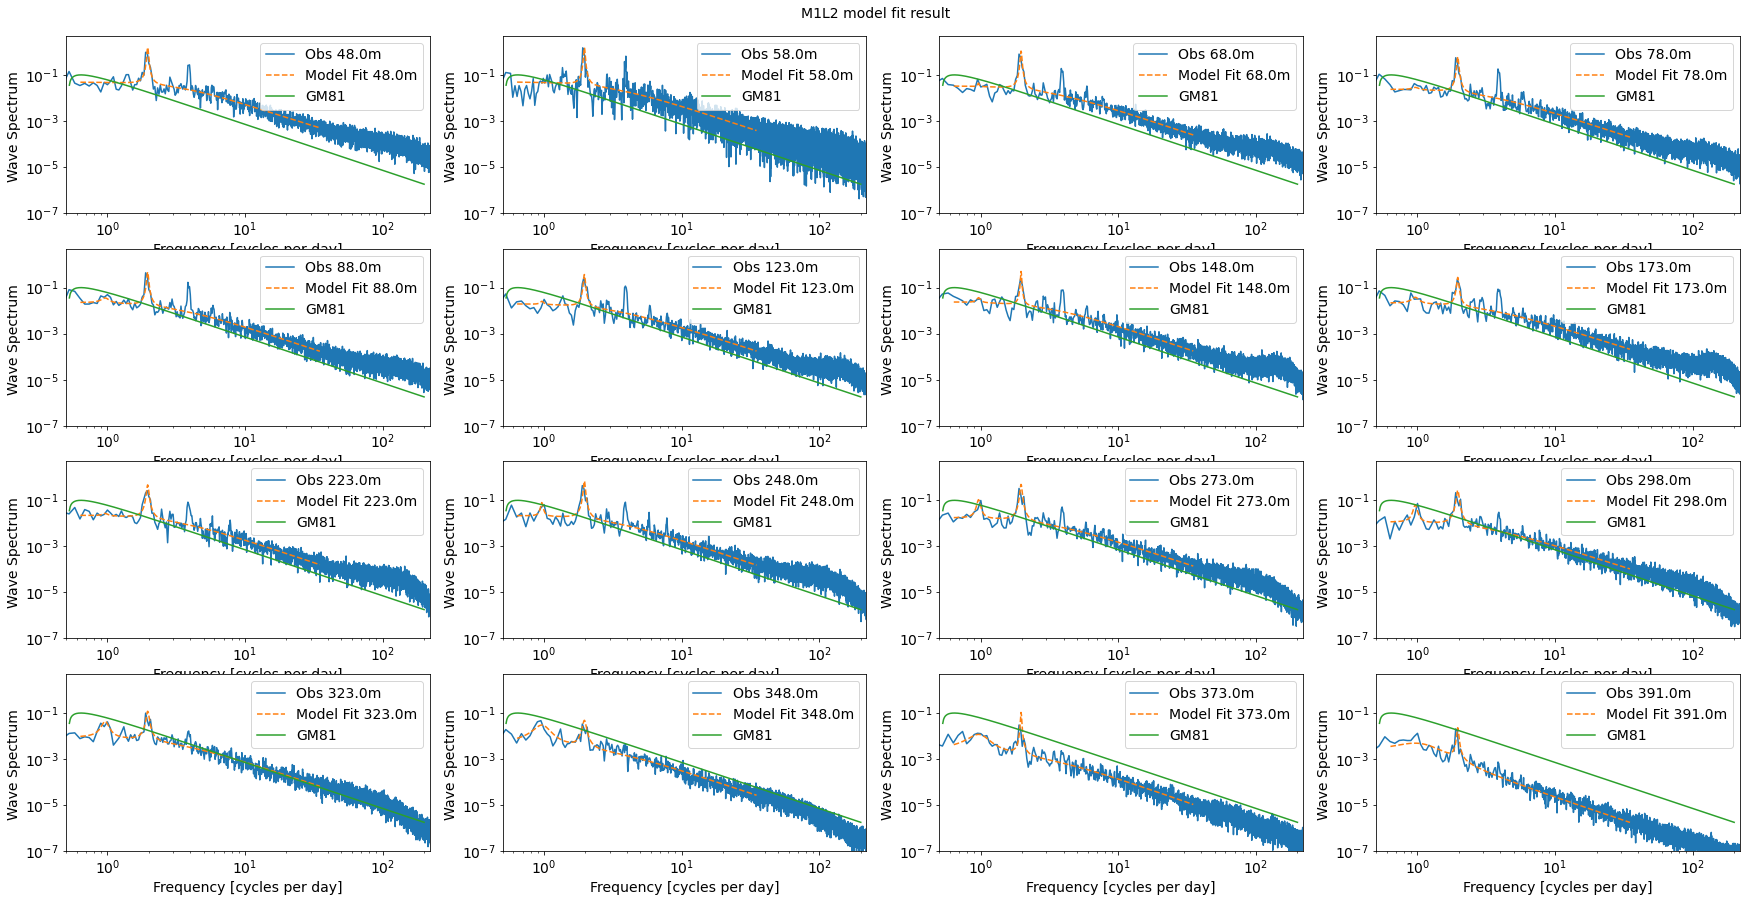

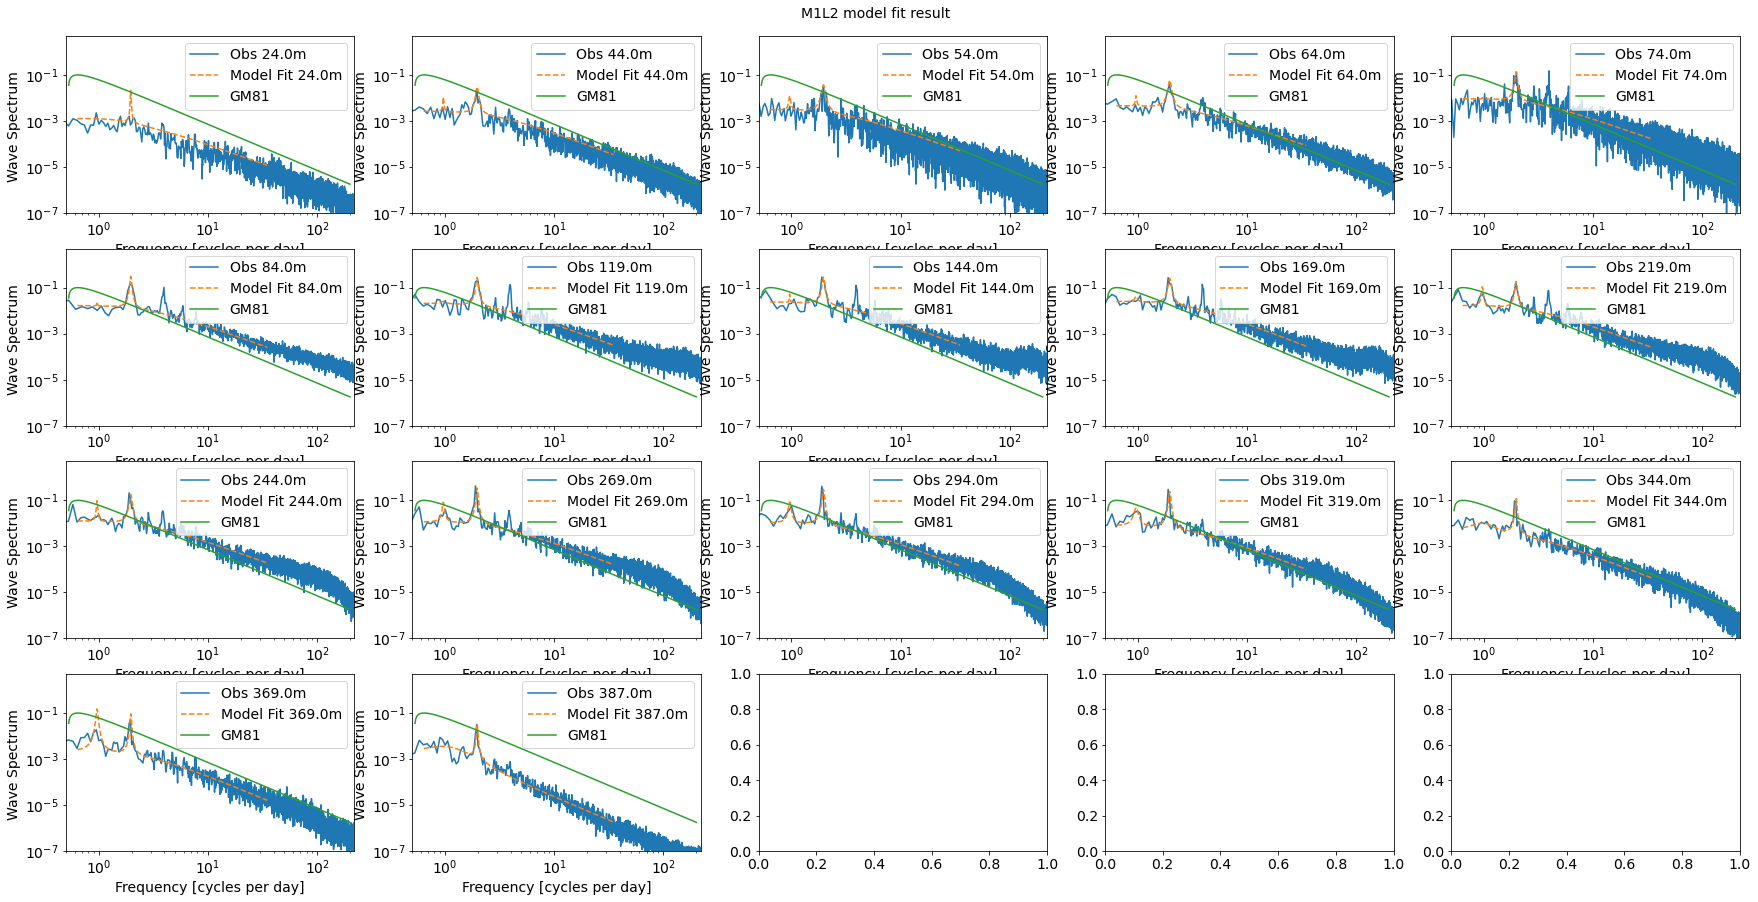

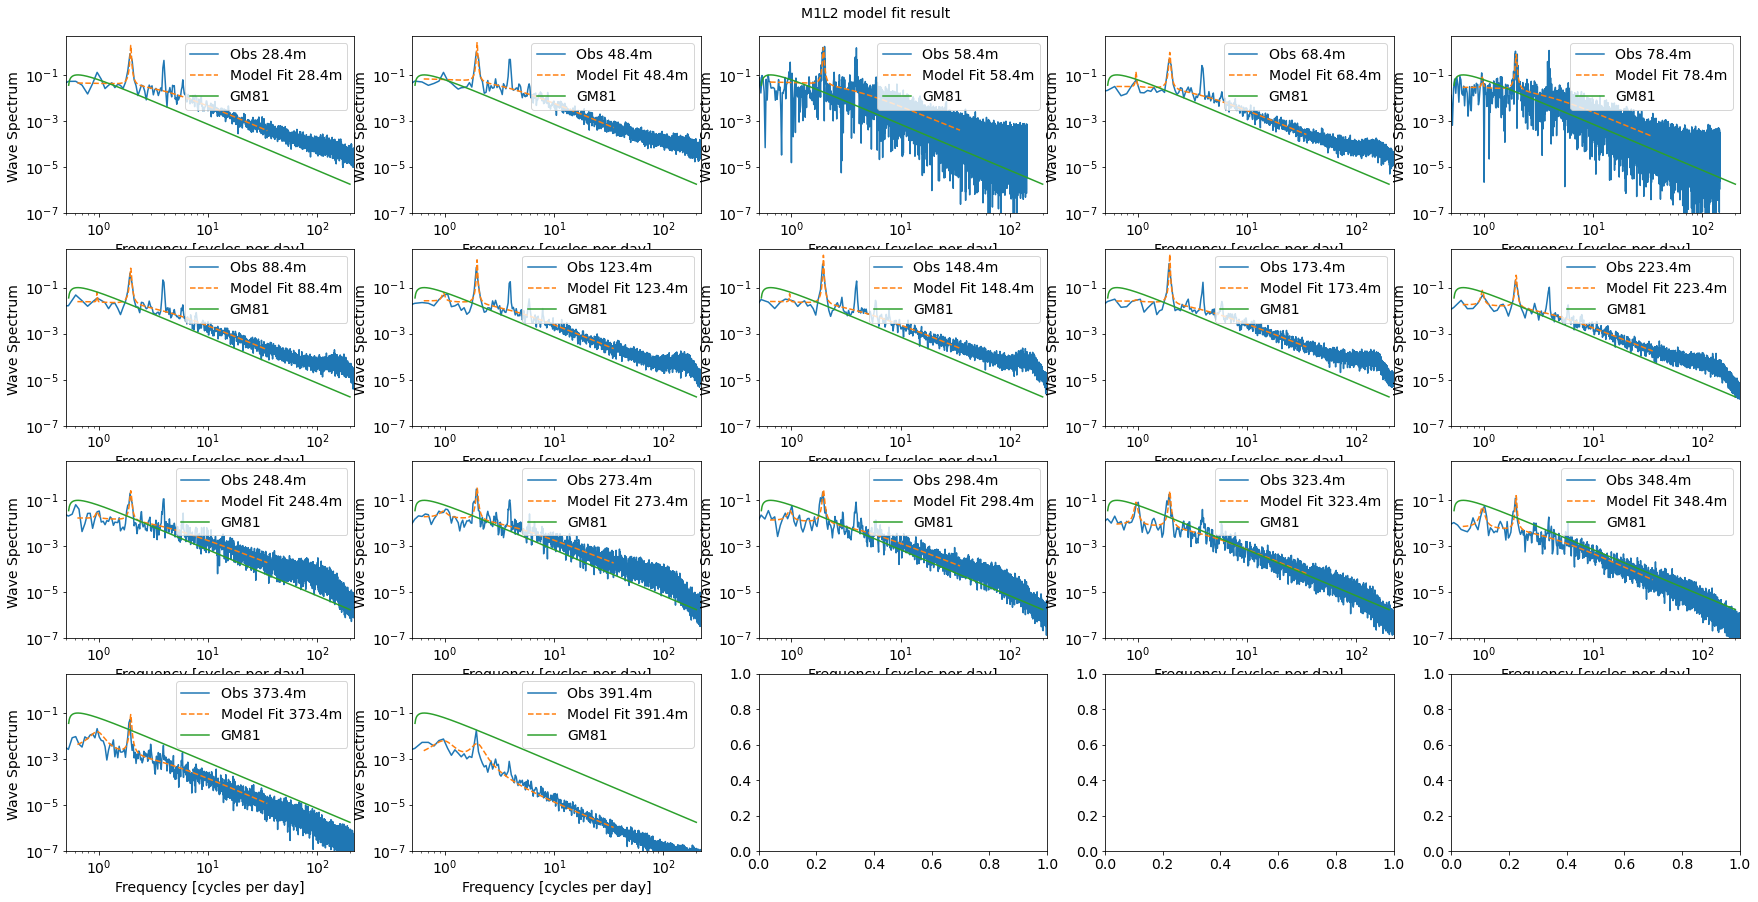

In [115]:
from functions import Plot_figure
#M1L2
Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P1, P_w_P1, 
                                       F_model_fit_list_P1_M1L2,P_model_fit_list_P1_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P2, F_w_P2, P_w_P2, 
                                       F_model_fit_list_P2_M1L2,P_model_fit_list_P2_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P3, F_w_P3, P_w_P3, 
                                       F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P4, F_w_P4, P_w_P4, 
                                       F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P5, F_w_P5, P_w_P5, 
                                       F_model_fit_list_P5_M1L2,P_model_fit_list_P5_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

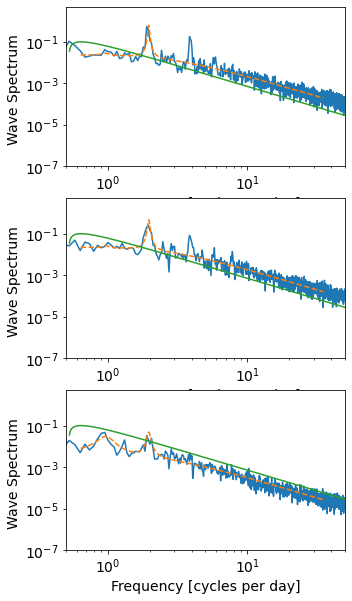

In [116]:
Sorted_Depths_P3 = Depths_P3.copy()
Sorted_Depths_P3.sort()
Sorted_Depths_P3 = [Sorted_Depths_P3[3],Sorted_Depths_P3[len(Sorted_Depths_P3)//2],Sorted_Depths_P3[-3]]

rows = len(Sorted_Depths_P3)
cols = 1
fig_KIM400, axes = plt.subplots(rows, cols, figsize=(5, 10))
axes = axes.flatten()

for i in range(len(Sorted_Depths_P3)):
    depth = Sorted_Depths_P3[i]
    idx = Depths_P3.index(depth)
    
    #plot obs first window
    axes[i].plot(F_w_P3[idx][0], P_w_P3[idx][0],label='Obs {}m'.format(Depths_P3[idx]))
    #plot model fit first window
    axes[i].plot(F_model_fit_list_P3_M1L2[idx][0],P_model_fit_list_P3_M1L2[idx][0],label='Model Fit {}m'.format(Depths_P3[idx]),linestyle='dashed')
    #plot GM
    axes[i].plot(omg*86400, GM_spectrum/86400,label = 'GM81')
    
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
#     axes[i].legend(loc="upper right")
    axes[i].set_ylim(1e-7, 5)
    axes[i].set_xlim(0.5,50)
    axes[i].set_xlabel('Frequency [cycles per day]')
    axes[i].set_ylabel('Wave Spectrum ')
    
fig_KIM400.savefig('KIM400_model_fit.png', bbox_inches='tight', dpi=300)

In [117]:
import pickle

Sorted_Depths_P3 = Depths_P3.copy()
Sorted_Depths_P3.sort()
Sorted_Depths_P3 = [Sorted_Depths_P3[3], Sorted_Depths_P3[len(Sorted_Depths_P3)//2], Sorted_Depths_P3[-3]]

idx_list = []
for i in range(len(Sorted_Depths_P3)):
    depth = Sorted_Depths_P3[i]
    idx_list.append(Depths_P3.index(depth))

data = {'Sorted_Depths': Sorted_Depths_P3,
        'F_obs': [F_w_P3[i][0] for i in idx_list],
        'P_obs': [P_w_P3[i][0] for i in idx_list],
        'F_model_fit': [F_model_fit_list_P3_M1L2[i][0] for i in idx_list],
        'P_model_fit': [P_model_fit_list_P3_M1L2[i][0] for i in idx_list],
        'F_gm': omg*86400,
        'P_gm': GM_spectrum/86400,        },


# Save the data
with open('KIM400 model fit P3.pkl', 'wb') as f:
    pickle.dump(data, f)

# Result Analysis

## Calculate whittle value sequentially

In [86]:
#define diurnal peak freq and bandwidth
diurnal_peak_freq      = 1 #cpd
diurnal_peak_bandwidth = 0.2
#define semidiurnal peak freq and bandwidth
semidiurnal_peak_freq      = 2 #cpd
semidiurnal_peak_bandwidth = 0.2

In [87]:
subset_p_P1_diurnal_peak      = Processing.Subset_peak(F_p_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P1_diurnal_peak      = Processing.Subset_peak(F_w_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P1_semidiurnal_peak  = Processing.Subset_peak(F_p_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P1_semidiurnal_peak  = Processing.Subset_peak(F_w_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P1_residual          = Processing.Subset_residual(subset_p_P1_diurnal_peak,subset_p_P1_semidiurnal_peak,subset_p_P1 )
subset_w_P1_residual          = Processing.Subset_residual(subset_w_P1_diurnal_peak,subset_w_P1_semidiurnal_peak,subset_w_P1 )

F_p_P1_L1_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_diurnal_peak)
P_p_P1_L1_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_diurnal_peak )
F_p_P1_L2_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_semidiurnal_peak  )
P_p_P1_L2_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_semidiurnal_peak  )
F_p_P1_residual = Processing.Select_frequency(F_p_P1,subset_p_P1_residual )
P_p_P1_residual = Processing.Select_frequency(P_p_P1,subset_p_P1_residual )

In [88]:
subset_p_P2_diurnal_peak      = Processing.Subset_peak(F_p_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P2_diurnal_peak      = Processing.Subset_peak(F_w_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P2_semidiurnal_peak  = Processing.Subset_peak(F_p_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P2_semidiurnal_peak  = Processing.Subset_peak(F_w_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P2_residual          = Processing.Subset_residual(subset_p_P2_diurnal_peak,subset_p_P2_semidiurnal_peak,subset_p_P2 )
subset_w_P2_residual          = Processing.Subset_residual(subset_w_P2_diurnal_peak,subset_w_P2_semidiurnal_peak,subset_w_P2 )

F_p_P2_L1_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_diurnal_peak)
P_p_P2_L1_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_diurnal_peak )
F_p_P2_L2_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_semidiurnal_peak  )
P_p_P2_L2_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_semidiurnal_peak  )
F_p_P2_residual = Processing.Select_frequency(F_p_P2,subset_p_P2_residual )
P_p_P2_residual = Processing.Select_frequency(P_p_P2,subset_p_P2_residual )

In [89]:
subset_p_P3_diurnal_peak      = Processing.Subset_peak(F_p_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P3_diurnal_peak      = Processing.Subset_peak(F_w_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P3_semidiurnal_peak  = Processing.Subset_peak(F_p_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P3_semidiurnal_peak  = Processing.Subset_peak(F_w_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P3_residual          = Processing.Subset_residual(subset_p_P3_diurnal_peak,subset_p_P3_semidiurnal_peak,subset_p_P3 )
subset_w_P3_residual          = Processing.Subset_residual(subset_w_P3_diurnal_peak,subset_w_P3_semidiurnal_peak,subset_w_P3 )

F_p_P3_L1_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_diurnal_peak)
P_p_P3_L1_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_diurnal_peak )
F_p_P3_L2_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_semidiurnal_peak  )
P_p_P3_L2_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_semidiurnal_peak  )
F_p_P3_residual = Processing.Select_frequency(F_p_P3,subset_p_P3_residual )
P_p_P3_residual = Processing.Select_frequency(P_p_P3,subset_p_P3_residual )

In [90]:
subset_p_P4_diurnal_peak      = Processing.Subset_peak(F_p_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P4_diurnal_peak      = Processing.Subset_peak(F_w_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P4_semidiurnal_peak  = Processing.Subset_peak(F_p_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P4_semidiurnal_peak  = Processing.Subset_peak(F_w_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P4_residual          = Processing.Subset_residual(subset_p_P4_diurnal_peak,subset_p_P4_semidiurnal_peak,subset_p_P4 )
subset_w_P4_residual          = Processing.Subset_residual(subset_w_P4_diurnal_peak,subset_w_P4_semidiurnal_peak,subset_w_P4 )

F_p_P4_L1_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_diurnal_peak)
P_p_P4_L1_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_diurnal_peak )
F_p_P4_L2_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_semidiurnal_peak  )
P_p_P4_L2_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_semidiurnal_peak  )
F_p_P4_residual = Processing.Select_frequency(F_p_P4,subset_p_P4_residual )
P_p_P4_residual = Processing.Select_frequency(P_p_P4,subset_p_P4_residual )

In [91]:
subset_p_P5_diurnal_peak      = Processing.Subset_peak(F_p_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P5_diurnal_peak      = Processing.Subset_peak(F_w_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P5_semidiurnal_peak  = Processing.Subset_peak(F_p_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P5_semidiurnal_peak  = Processing.Subset_peak(F_w_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P5_residual          = Processing.Subset_residual(subset_p_P5_diurnal_peak,subset_p_P5_semidiurnal_peak,subset_p_P5 )
subset_w_P5_residual          = Processing.Subset_residual(subset_w_P5_diurnal_peak,subset_w_P5_semidiurnal_peak,subset_w_P5 )

F_p_P5_L1_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_diurnal_peak)
P_p_P5_L1_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_diurnal_peak )
F_p_P5_L2_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_semidiurnal_peak  )
P_p_P5_L2_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_semidiurnal_peak  )
F_p_P5_residual = Processing.Select_frequency(F_p_P5,subset_p_P5_residual )
P_p_P5_residual = Processing.Select_frequency(P_p_P5,subset_p_P5_residual )

Text(0.5, 1.0, 'Segmentation of temp residual spectrum at 89m')

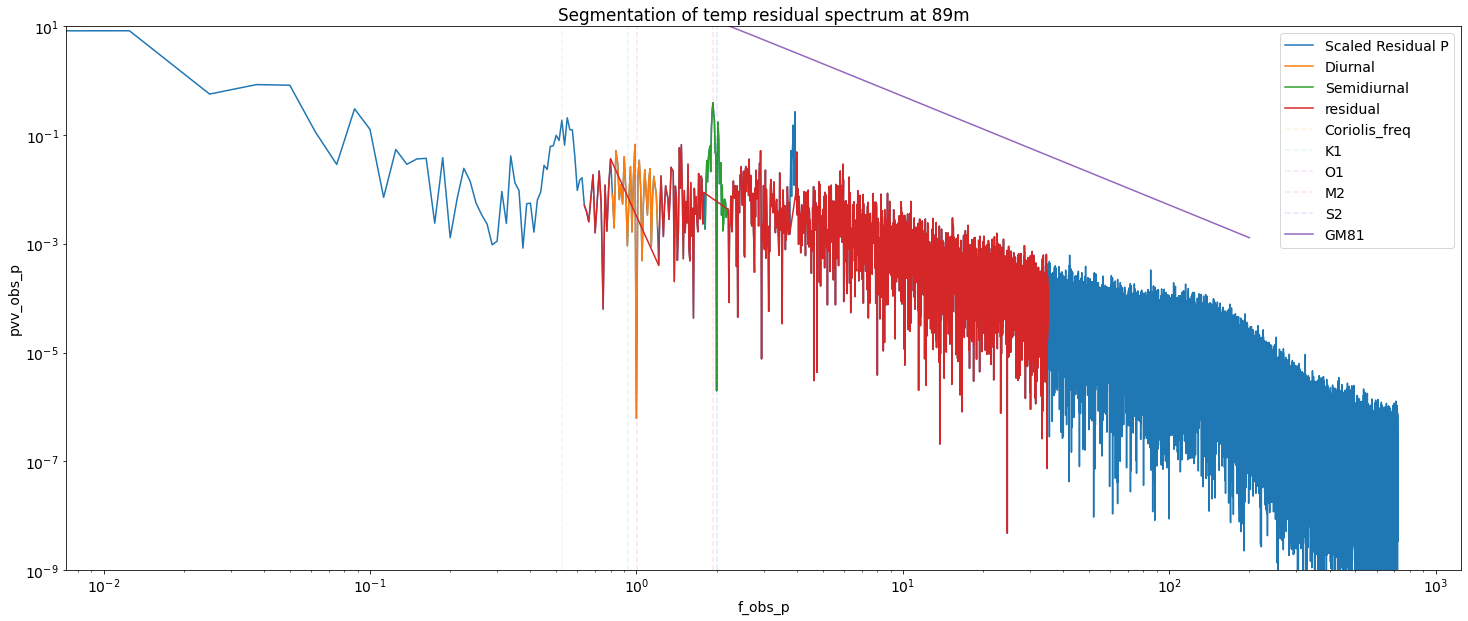

In [92]:
# total depth is ~400m
# interest_depth = 110.7
idx = Depths_P1.index(interest_depth)

plt.plot(F_p_P1[idx][0],P_p_P1[idx][0],label='Scaled Residual P')
# plt.plot(F_p_P1_modulated[idx][0],P_p_P1_modulated[idx][0],label='Processed & scaled Residual P')
plt.plot(F_p_P1_L1_peak[idx][0],P_p_P1_L1_peak[idx][0],label='Diurnal')
plt.plot(F_p_P1_L2_peak[idx][0],P_p_P1_L2_peak[idx][0],label='Semidiurnal')
plt.plot(F_p_P1_residual[idx][0],P_p_P1_residual[idx][0],label='residual')


for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.105)

# plt.plot(F_residual_w[idx],P_residual_w_raw[idx],label='Raw Obs Residual W')
# plt.plot(F_residual_w[idx],P_residual_w[idx],'-.',label='Scaled Residual W')
# plt.plot(F_residual_w_Modulated[idx],P_residual_w_Modulated[idx],'-.',label='Processed & scaled Residual W')
plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Segmentation of temp residual spectrum at {}m'.format(interest_depth))

In [93]:
#whittle_total per points
whittle_total_M1L2_P1         = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1,                 Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L2_P1      = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_diurnal_peak,    Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L2_P1  = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_semidiurnal_peak,Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
#whittle_residual per points
whittle_residual_M1L2_P1     = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_residual,        Soln_model_fit_list_P1_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.5\functions\Cov.py:121: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [94]:
whittle_total_M1L2_P2         = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2,                 Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P2      = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_diurnal_peak,    Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P2  = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_semidiurnal_peak,Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P2     = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_residual,        Soln_model_fit_list_P2_M1L2,M1L2_no_noise)

In [95]:
whittle_total_M1L2_P3         = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3,                 Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P3      = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_diurnal_peak,    Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P3  = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_semidiurnal_peak,Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P3     = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_residual,        Soln_model_fit_list_P3_M1L2,M1L2_no_noise)

In [96]:
whittle_total_M1L2_P4         = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4,                 Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P4      = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_diurnal_peak,    Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P4  = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_semidiurnal_peak,Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P4     = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_residual,        Soln_model_fit_list_P4_M1L2,M1L2_no_noise)

In [97]:
whittle_total_M1L2_P5         = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5,                 Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P5      = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_diurnal_peak,    Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P5  = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_semidiurnal_peak,Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P5     = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_residual,        Soln_model_fit_list_P5_M1L2,M1L2_no_noise)

## Construct a PD DataFrame that contain all the results

In [98]:
#M1L2
whittle_total_M1L2_df_P1        = Processing.Transfer_list_to_df(whittle_total_M1L2_P1,       Depths_P1,'whittle_total')
whittle_diurnal_M1L2_df_P1      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P1,     Depths_P1,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P1  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P1, Depths_P1,'whittle_semidiurnal')
whittle_residual_M1L2_df_P1     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P1,    Depths_P1,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P1 = pd.concat([whittle_total_M1L2_df_P1, 
                                whittle_diurnal_M1L2_df_P1, 
                                whittle_semidiurnal_M1L2_df_P1,
                                whittle_residual_M1L2_df_P1 ], axis=1)
whittle_df_M1L2_P1

whittle_total  whittle_diurnal  whittle_semidiurnal  whittle_residual
59.0        5.454823         2.550870             1.070436          5.542173
299.0       6.692547         2.672701             2.083138          6.795968
392.0      10.186921         4.170312             4.335552         10.329159
49.0        5.368726         2.414919             1.018990          5.456260
69.0        5.743010         2.733712             1.409214          5.831017
89.0             NaN              NaN                  NaN               NaN
29.0        6.762143         3.399481             3.038780          6.847069
79.0        6.092524         3.089143             1.939428          6.178294
372.0       8.306915         3.325743             3.457738          8.424732
124.0       6.605550         3.463720             2.439285          6.693138
149.0       6.249170         2.799853             1.778718          6.344088
174.0       5.888176         2.630233             1.322353          5.981944
224.0       6.181862         2.605025             1.893140          6.276131
249.0       6.322209         2.626607             1.998183          6.418325
274.0       6.505620         2.881829             1.976721          6.603330
324.0       7.001321         2.702940             2.376681          7.108263
349.0       7.659004         2.883600             3.087552          7.771027
59.0        6.404651         2.902377             2.163357          6.497458
299.0       6.607822         2.840321             2.572013          6.701344
392.0      10.117519         4.080560             4.607215         10.255913
49.0        6.805127         3.146520             2.476400          6.900855
69.0        6.180409         3.069992             1.944941          6.268450
89.0        5.691635         2.826268             1.513366          5.776053
29.0        8.261902         4.556048             4.850253          8.347206
79.0        5.930404         2.925573             1.748611          6.016536
372.0       8.406421         3.282602             3.821894          8.522776
124.0       5.916194         2.580390             1.451475          6.009683
149.0       5.965525         2.509760             1.362233          6.062113
174.0       5.828577         2.538808             1.219792          5.923241
224.0       5.946245         2.914238             1.618186          6.034456
249.0       5.958272         2.759736             1.741719          6.047142
274.0       6.170311         2.782001             2.174923          6.258805
324.0       7.025870         3.189135             2.953101          7.120665
349.0       7.567745         3.425122             3.236013          7.669310

In [99]:
#M1L2
whittle_total_M1L2_df_P2        = Processing.Transfer_list_to_df(whittle_total_M1L2_P2,       Depths_P2,'whittle_total')
whittle_diurnal_M1L2_df_P2      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P2,     Depths_P2,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P2  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P2, Depths_P2,'whittle_semidiurnal')
whittle_residual_M1L2_df_P2     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P2,    Depths_P2,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P2 = pd.concat([whittle_total_M1L2_df_P2, 
                                whittle_diurnal_M1L2_df_P2, 
                                whittle_semidiurnal_M1L2_df_P2,
                                whittle_residual_M1L2_df_P2 ], axis=1)

In [100]:
#M1L2
whittle_total_M1L2_df_P3        = Processing.Transfer_list_to_df(whittle_total_M1L2_P3,       Depths_P3,'whittle_total')
whittle_diurnal_M1L2_df_P3      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P3,     Depths_P3,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P3  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P3, Depths_P3,'whittle_semidiurnal')
whittle_residual_M1L2_df_P3     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P3,    Depths_P3,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P3 = pd.concat([whittle_total_M1L2_df_P3, 
                                whittle_diurnal_M1L2_df_P3, 
                                whittle_semidiurnal_M1L2_df_P3,
                                whittle_residual_M1L2_df_P3 ], axis=1)

In [101]:
#M1L2
whittle_total_M1L2_df_P4        = Processing.Transfer_list_to_df(whittle_total_M1L2_P4,       Depths_P4,'whittle_total')
whittle_diurnal_M1L2_df_P4      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P4,     Depths_P4,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P4  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P4, Depths_P4,'whittle_semidiurnal')
whittle_residual_M1L2_df_P4     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P4,    Depths_P4,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P4 = pd.concat([whittle_total_M1L2_df_P4, 
                                whittle_diurnal_M1L2_df_P4, 
                                whittle_semidiurnal_M1L2_df_P4,
                                whittle_residual_M1L2_df_P4 ], axis=1)

In [102]:
#M1L2
whittle_total_M1L2_df_P5        = Processing.Transfer_list_to_df(whittle_total_M1L2_P5,       Depths_P5,'whittle_total')
whittle_diurnal_M1L2_df_P5      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P5,     Depths_P5,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P5  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P5, Depths_P5,'whittle_semidiurnal')
whittle_residual_M1L2_df_P5     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P5,    Depths_P5,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P5 = pd.concat([whittle_total_M1L2_df_P5, 
                                whittle_diurnal_M1L2_df_P5, 
                                whittle_semidiurnal_M1L2_df_P5,
                                whittle_residual_M1L2_df_P5 ], axis=1)

# Construct a pd dataframe

In [103]:
final_P1 = Processing.Create_df(start_date_list_P1,end_date_list_P1,year_list_P1,temp_avg_list_P1,Var_total_P1,HA_var_P1,Var_modulated_P1,Var_subtidal_P1,Depths_P1)
final_P2 = Processing.Create_df(start_date_list_P2,end_date_list_P2,year_list_P2,temp_avg_list_P2,Var_total_P2,HA_var_P2,Var_modulated_P2,Var_subtidal_P2,Depths_P2)
final_P3 = Processing.Create_df(start_date_list_P3,end_date_list_P3,year_list_P3,temp_avg_list_P3,Var_total_P3,HA_var_P3,Var_modulated_P3,Var_subtidal_P3,Depths_P3)
final_P4 = Processing.Create_df(start_date_list_P4,end_date_list_P4,year_list_P4,temp_avg_list_P4,Var_total_P4,HA_var_P4,Var_modulated_P4,Var_subtidal_P4,Depths_P4)
final_P5 = Processing.Create_df(start_date_list_P5,end_date_list_P5,year_list_P5,temp_avg_list_P5,Var_total_P5,HA_var_P5,Var_modulated_P5,Var_subtidal_P5,Depths_P5)

final_df = pd.concat([final_P1, final_P2,final_P3,final_P4,final_P5])
final_df

start_date    end_date  year  mean_temp  total_var    HA_var  \
59.0   2012-02-03  2012-04-23  2012  26.954905   1.102385  0.114471   
299.0  2012-02-03  2012-04-23  2012  12.348471   0.402338  0.022164   
392.0  2012-02-03  2012-04-23  2012   9.856034   0.095518  0.015056   
49.0   2012-02-03  2012-04-23  2012  27.936733   0.936634  0.131559   
69.0   2012-02-03  2012-04-23  2012  26.057319   1.013484  0.075202   
...           ...         ...   ...        ...        ...       ...   
273.4  2014-04-22  2014-07-11  2014  12.011761   0.394111  0.053415   
298.4  2014-04-22  2014-07-11  2014  11.165978   0.291265  0.037825   
323.4  2014-04-22  2014-07-11  2014  10.520750   0.183205  0.021735   
348.4  2014-04-22  2014-07-11  2014   9.983793   0.119286  0.014096   
373.4  2014-04-22  2014-07-11  2014   9.503091   0.077304  0.010873   

       var_modulated  var_subtidal   season  
59.0        0.455898      0.411080  Feb-Apr  
299.0       0.154966      0.195325  Feb-Apr  
392.0       0.018057      0.058163  Feb-Apr  
49.0        0.474723      0.227155  Feb-Apr  
69.0        0.345493      0.483844  Feb-Apr  
...              ...           ...      ...  
273.4       0.208514      0.102770  May-Jul  
298.4       0.151639      0.082819  May-Jul  
323.4       0.087820      0.065147  May-Jul  
348.4       0.062362      0.037710  May-Jul  
373.4       0.031475      0.031990  May-Jul  

[168 rows x 9 columns]

In [104]:
# #plot mean
# season = final_df['season'].drop_duplicates()
# year = final_df['year'].drop_duplicates()
# fig, axs = plt.subplots(2,4, figsize=(25, 13))
# fig.text(0.5, 1, 'Mean Temperature profile 2012-2014', ha='center', va='center')    
# for i in range(len(season)):   # 4season
#     for ii in year:
#         selected_df = final_df[(final_df['season']==season.iloc[i]) & (final_df['year']==ii)].sort_index()
        
#         axs[0,i].plot(selected_df['mean_temp'],-selected_df.index,)
#         axs[0,i].set_title(season.iloc[i])
#         axs[0,i].set_ylabel('Depth (m)')
#         axs[0,i].set_xlabel('Mean Temp (℃)')
        
#         axs[1,i].plot(selected_df['mean_temp_no_mean'],-selected_df.index,)
#         axs[1,i].set_title(season.iloc[i])
#         axs[1,i].set_ylabel('Depth (m)')
#         axs[1,i].set_xlabel('Mean Temp no mean (℃)')

In [105]:
whittle_df_final_M1L2 = pd.concat([whittle_df_M1L2_P1,
                                   whittle_df_M1L2_P2, 
                                   whittle_df_M1L2_P3,
                                   whittle_df_M1L2_P4,
                                   whittle_df_M1L2_P5])

In [106]:
#M1L2
Soln_model_fit_df_P1_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P1_M1L2,Depths_P1,'solution')
Soln_model_fit_df_P2_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P2_M1L2,Depths_P2,'solution')
Soln_model_fit_df_P3_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P3_M1L2,Depths_P3,'solution')
Soln_model_fit_df_P4_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P4_M1L2,Depths_P4,'solution')
Soln_model_fit_df_P5_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P5_M1L2,Depths_P5,'solution')
#Assemble all period
Soln_model_fit_df_final_M1L2 = pd.concat([Soln_model_fit_df_P1_M1L2,
                                          Soln_model_fit_df_P2_M1L2,
                                          Soln_model_fit_df_P3_M1L2,
                                          Soln_model_fit_df_P4_M1L2,
                                          Soln_model_fit_df_P5_M1L2,])

In [107]:
Var_list_P1_M1L2 = Processing.Cal_var_from_Periodogram(F_model_fit_list_P1_M1L2,P_model_fit_list_P1_M1L2)
Var_list_P2_M1L2 = Processing.Cal_var_from_Periodogram(F_model_fit_list_P2_M1L2,P_model_fit_list_P2_M1L2)
Var_list_P3_M1L2 = Processing.Cal_var_from_Periodogram(F_model_fit_list_P3_M1L2,P_model_fit_list_P3_M1L2)
Var_list_P4_M1L2 = Processing.Cal_var_from_Periodogram(F_model_fit_list_P4_M1L2,P_model_fit_list_P4_M1L2)
Var_list_P5_M1L2 = Processing.Cal_var_from_Periodogram(F_model_fit_list_P5_M1L2,P_model_fit_list_P5_M1L2)

Var_df_P1_M1L2 = Processing.Transfer_list_to_df(Var_list_P1_M1L2,Depths_P1,'var_model-fit')
Var_df_P2_M1L2 = Processing.Transfer_list_to_df(Var_list_P2_M1L2,Depths_P2,'var_model-fit')
Var_df_P3_M1L2 = Processing.Transfer_list_to_df(Var_list_P3_M1L2,Depths_P3,'var_model-fit')
Var_df_P4_M1L2 = Processing.Transfer_list_to_df(Var_list_P4_M1L2,Depths_P4,'var_model-fit')
Var_df_P5_M1L2 = Processing.Transfer_list_to_df(Var_list_P5_M1L2,Depths_P5,'var_model-fit')

Var_df_final_M1L2 = pd.concat([Var_df_P1_M1L2,
                               Var_df_P2_M1L2,
                               Var_df_P3_M1L2,
                               Var_df_P4_M1L2,
                               Var_df_P5_M1L2,])

total var: 0.8676754
subtidal var: 0.27059369444461523
HA var 0.2042682918864844
subset var: 0.30664632083960036
model var calculated from psd (estimated by acf through bouchner) 0.3050377473816398
model var calculated from parameters: 0.36579961568401675


C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.5\functions\Cov.py:121: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


model var calculated from sample: 0.31379092745249954


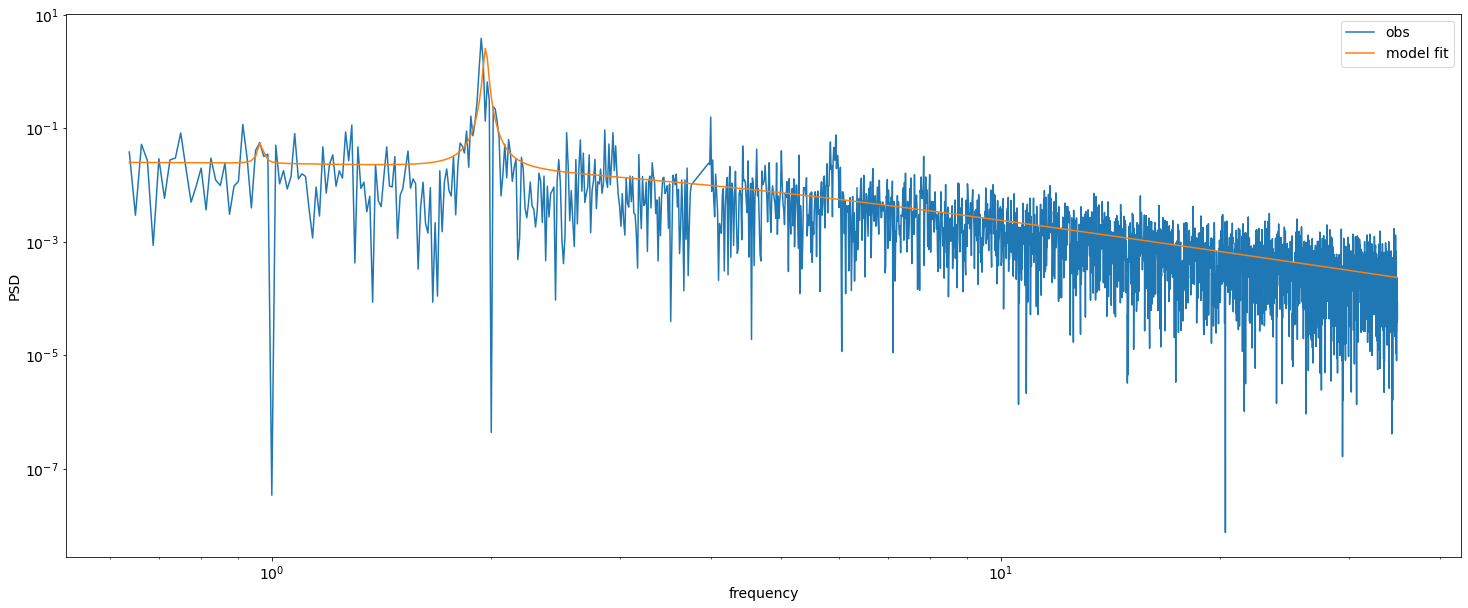

In [108]:
def M1L2_no_noise_sample(x,xpr,params):
    dx = x - xpr
    return M1L2_no_noise(dx,params)

from gptide import GPtideScipy
sample_interval_days = 50/36400  # day^-1 
sample_duration = 5 #days
sample_time = np.arange(0,sample_duration,sample_interval_days)
x = sample_time[:,None]
noise = 0

print('total var:',Var_total_P4[3][0])
print('subtidal var:',Var_subtidal_P4[3][0])
print('HA var',HA_var_P4[3][0])
print('subset var:',Var_modulated_P4[3][0])
example_solution = Soln_model_fit_list_P4_M1L2[3][0]
print('model var calculated from psd (estimated by acf through bouchner)',Var_list_P4_M1L2[3][0])
print('model var calculated from parameters:',example_solution[0]**2+example_solution[2]**2+example_solution[4]**2)
GP1 = GPtideScipy(x, x, noise, M1L2_no_noise_sample, example_solution, )
sample = GP1.prior(samples=1).T
print('model var calculated from sample:',sample.var())

plt.plot(F_p_P5_modulated[2][0],P_p_P5_modulated[2][0],label='obs')
plt.plot(F_model_fit_list_P5_M1L2[2][0],P_model_fit_list_P5_M1L2[2][0],label='model fit')
plt.xscale("log")
plt.yscale("log")
plt.ylabel('PSD')
plt.xlabel('frequency')
plt.legend()

In [109]:
from speccy import utils as ut
from speccy import sick_tricks as gary
n = len(Time_P2_Window[5][0])
delta = (Time_P2_Window[5][0][1]-Time_P2_Window[5][0][0]).astype('float')/1e9/86400  # day^-1 
tt = ut.taus(n, delta)
acf = M1L2_no_noise(tt,Soln_model_fit_list_P2_M1L2[5][0])
print('acf var',acf[0])
ff,psd = gary.bochner(acf, delta=delta, bias = True)
print('psd var',Cal_var_from_PSD1(ff[ff>=0],psd[ff>=0]))
example_solution = Soln_model_fit_list_P2_M1L2[5][0]
print('model var calculated from parameters:',example_solution[0]**2+example_solution[2]**2+example_solution[4]**2)
#SUBSET
print('psd subset var',Cal_var_from_PSD1(ff[ff>=0][subset_p_P2[5][0]],psd[ff>=0][subset_p_P2[5][0]]))
print('model var calculated from psd (estimated by acf through bouchner)',Var_list_P2_M1L2[5][0])
GP1 = GPtideScipy(x, x, noise, M1L2_no_noise_sample, example_solution, )
sample = GP1.prior(samples=1).T
print('model var calculated from sample:',sample.var())

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 1D Internal wave modeling\notebooks\1D internal tide temp model fit V1.5\functions\Cov.py:121: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


acf var 0.4493481607997472
psd var 0.44967182828410235
model var calculated from parameters: 0.44934816079874723
psd subset var 0.38717514685026644
model var calculated from psd (estimated by acf through bouchner) 0.38717514685026644
model var calculated from sample: 0.3765473558077119


In [110]:
#M1L2
final_df_M1L2 = Processing.Finalise_df(Soln_model_fit_df_final_M1L2, 
                                       Var_df_final_M1L2,
                                       M1L2_parameter_name,
                                       whittle_df_final_M1L2, 
                                       'KIM400','M1L2',
                                       final_df)

final_df_combined = final_df_M1L2
final_df_combined.to_csv('KIM400 Model fit parameters.csv', index=False)
final_df_combined

site  depth  start_date    end_date  year  mean_temp  total_var  \
0    KIM400  -29.0  2012-02-03  2012-04-23  2012  29.296369   0.355252   
1    KIM400  -49.0  2012-02-03  2012-04-23  2012  27.936733   0.936634   
2    KIM400  -59.0  2012-02-03  2012-04-23  2012  26.954905   1.102385   
3    KIM400  -69.0  2012-02-03  2012-04-23  2012  26.057319   1.013484   
4    KIM400  -79.0  2012-02-03  2012-04-23  2012  25.292833   0.759939   
..      ...    ...         ...         ...   ...        ...        ...   
163  KIM400 -298.4  2014-04-22  2014-07-11  2014  11.165978   0.291265   
164  KIM400 -323.4  2014-04-22  2014-07-11  2014  10.520750   0.183205   
165  KIM400 -348.4  2014-04-22  2014-07-11  2014   9.983793   0.119286   
166  KIM400 -373.4  2014-04-22  2014-07-11  2014   9.503091   0.077304   
167  KIM400 -391.4  2014-04-22  2014-07-11  2014   9.203585   0.053722   

    model_type    HA_var  var_modulated  ...  ν_matern1   η_peak1    ℓ_peak1  \
0         M1L2  0.010287       0.096050  ...   0.989199   0.04064       40.0   
1         M1L2  0.131559       0.474723  ...   1.551767  0.583953   0.046652   
2         M1L2  0.114471       0.455898  ...    1.01798  0.044651  24.234582   
3         M1L2  0.075202       0.345493  ...   1.053288  0.032976  14.043334   
4         M1L2  0.049057       0.222627  ...   1.012518  0.037103   9.560396   
..         ...       ...            ...  ...        ...       ...        ...   
163       M1L2  0.037825       0.151639  ...     0.9284  0.089463   1.691256   
164       M1L2  0.021735       0.087820  ...   0.996602  0.055605  32.355316   
165       M1L2  0.014096       0.062362  ...        NaN       NaN        NaN   
166       M1L2  0.010873       0.031475  ...   0.518124  0.183828   0.178357   
167       M1L2  0.005684       0.010310  ...    1.60308  0.097698    0.43397   

      η_peak2   ℓ_peak2 whittle_total whittle_diurnal whittle_semidiurnal  \
0    0.128132  6.093926      6.762143        3.399481            3.038780   
1    0.387158  5.732811      5.368726        2.414919            1.018990   
2    0.393049  5.993261      5.454823        2.550870            1.070436   
3    0.328994  6.568284      5.743010        2.733712            1.409214   
4    0.259268  7.524656      6.092524        3.089143            1.939428   
..        ...       ...           ...             ...                 ...   
163  0.254581   2.88911      6.615666        3.078446            1.870184   
164  0.182209  2.759884      7.233870        3.789564            2.566900   
165       NaN       NaN           NaN             NaN                 NaN   
166  0.068386  5.164903      8.554131        3.887757            4.055587   
167  0.052443   4.24909     10.918426        4.559494            5.108343   

     whittle_residual  var_model-fit  
0            6.847069       0.096911  
1            5.456260       0.474696  
2            5.542173       0.461507  
3            5.831017       0.356574  
4            6.178294       0.228954  
..                ...            ...  
163          6.714934       0.149145  
164          7.331084       0.084305  
165               NaN       0.061427  
166          8.663973       0.031121  
167         11.064271       0.010408  

[168 rows x 23 columns]

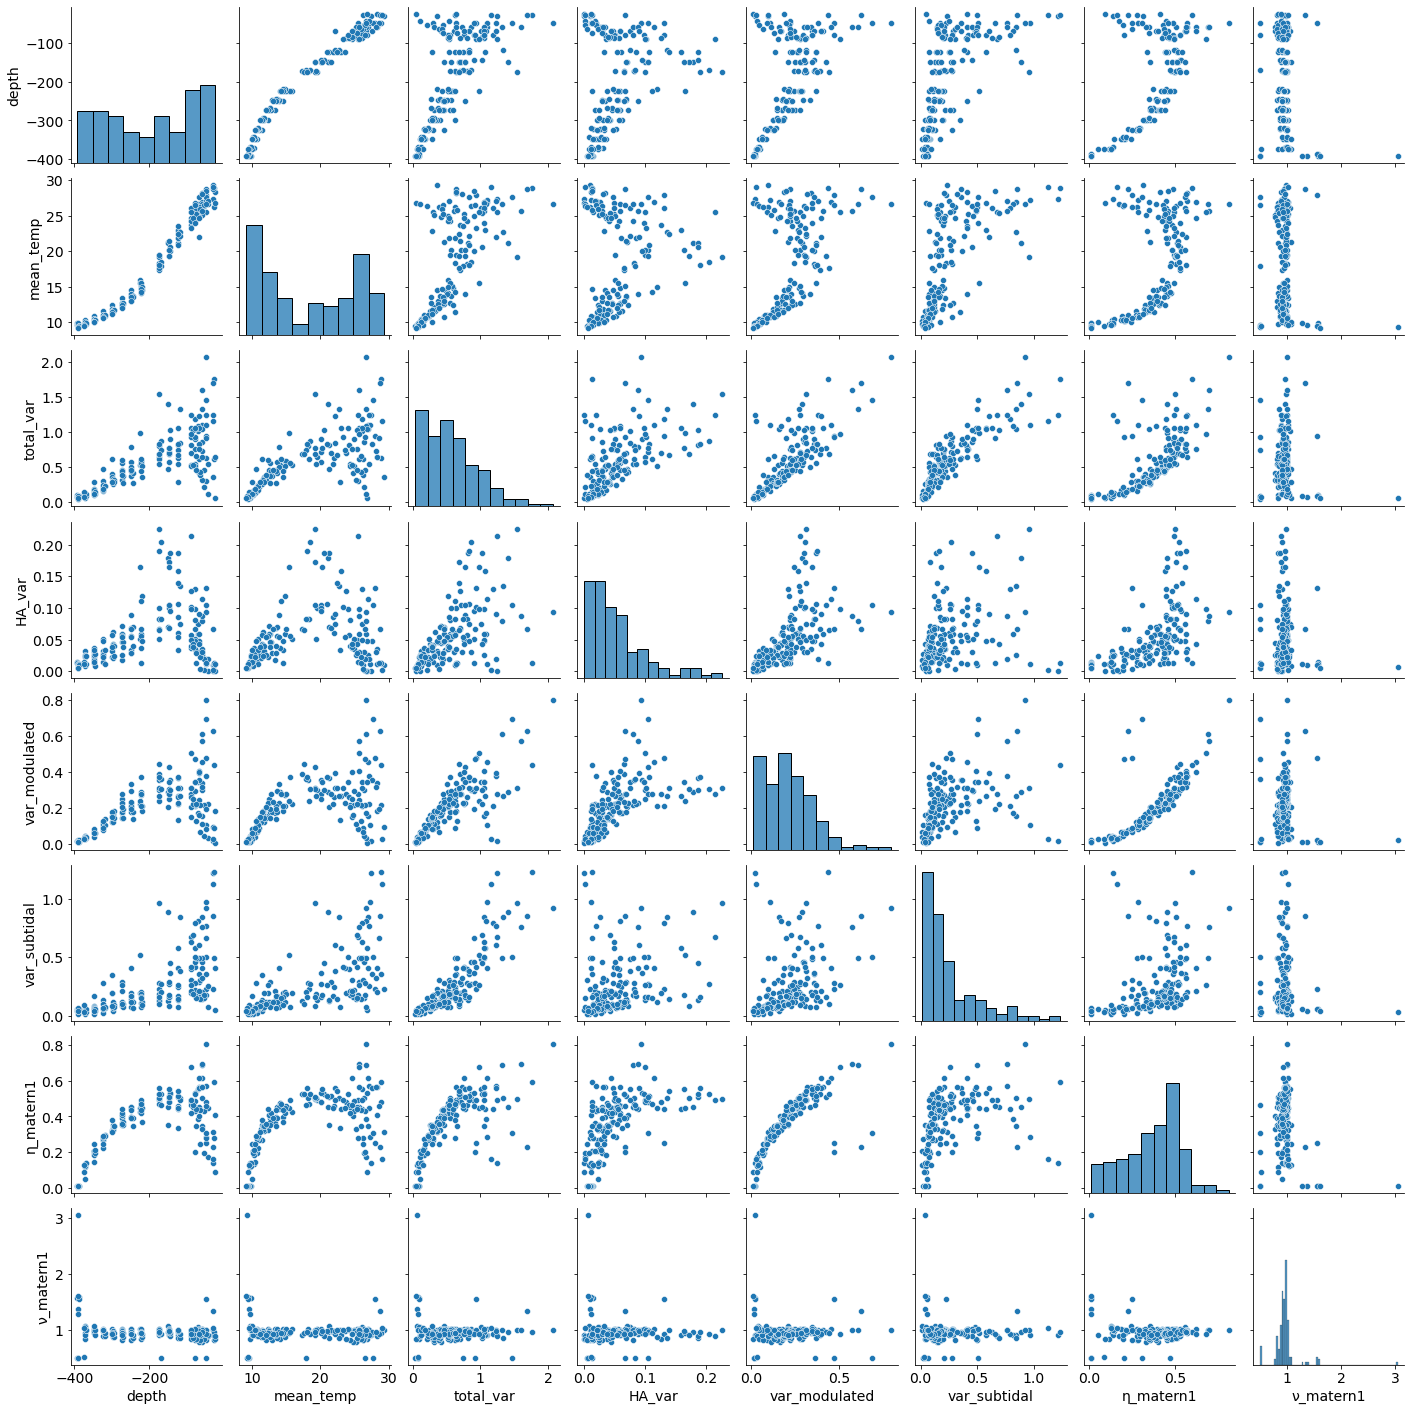

In [111]:
import seaborn as sns
#pair plot for parameter
sns.pairplot(final_df_M1L2.iloc[:, [1] + list(range(5, 14))])
plt.show()

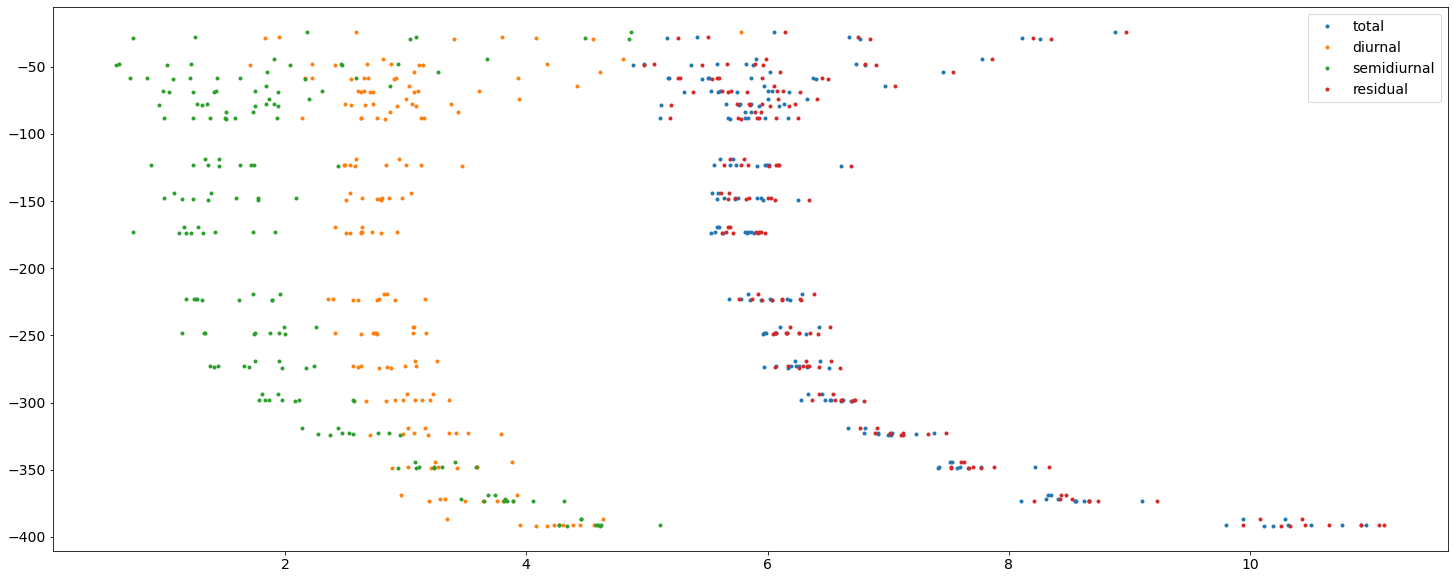

In [112]:
#pair plot for whittle value
plt.plot(final_df_M1L2['whittle_total'],final_df_M1L2['depth'],'.',label='total')
plt.plot(final_df_M1L2['whittle_diurnal'],final_df_M1L2['depth'],'.',label='diurnal')
plt.plot(final_df_M1L2['whittle_semidiurnal'],final_df_M1L2['depth'],'.',label='semidiurnal')
plt.plot(final_df_M1L2['whittle_residual'],final_df_M1L2['depth'],'.',label='residual')
plt.legend()

var1 obs 0.25119712422300416
var1 model fit 0.2534691156954768


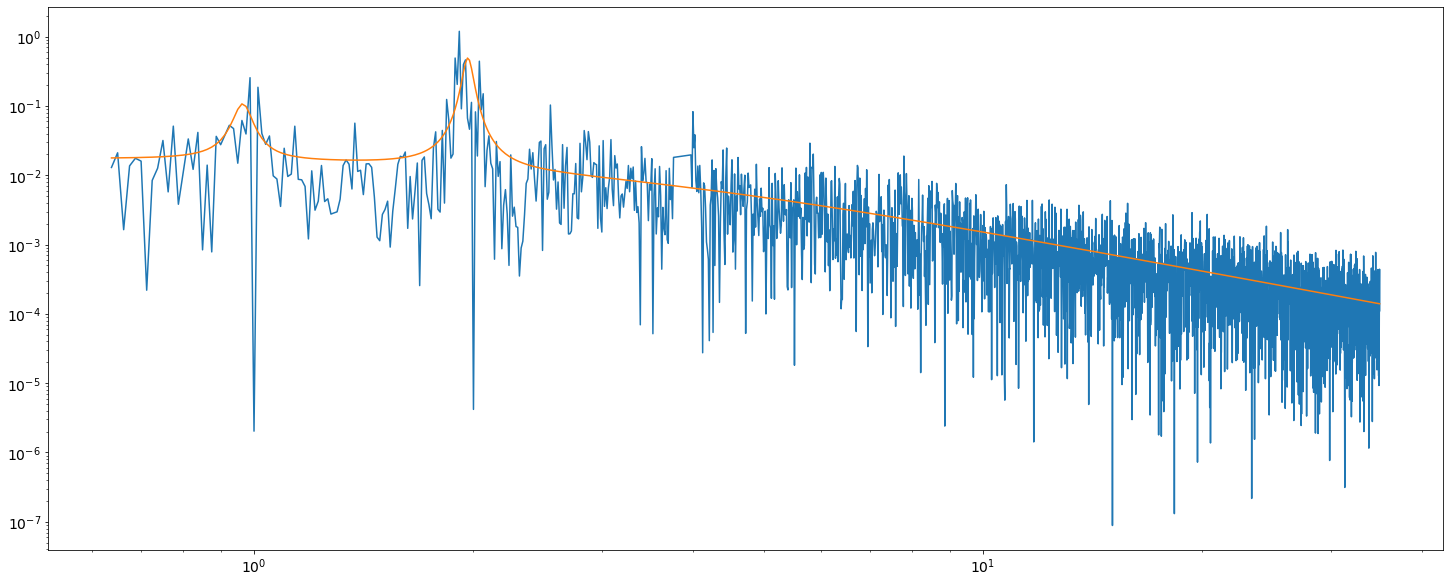

In [113]:
plt.plot(F_p_P3_modulated[5][0],P_p_P3_modulated[5][0])
plt.plot(F_model_fit_list_P3_M1L2[5][0],P_model_fit_list_P3_M1L2[5][0])
plt.xscale("log")
plt.yscale("log")
print('var1 obs',Cal_var_from_PSD1(F_p_P3_modulated[5][0],P_p_P3_modulated[5][0]))
print('var1 model fit',Cal_var_from_PSD1(F_model_fit_list_P3_M1L2[5][0],P_model_fit_list_P3_M1L2[5][0]))